In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import seaborn as sns

from matplotlib.patches import Patch 
from scipy.stats import kendalltau
from scipy.stats import ttest_rel
from statsmodels.formula.api import ols
from statsmodels.tsa.seasonal import seasonal_decompose

# Read data

In [70]:
sales_data = pd.read_csv('adventure_works_purchase_orders.csv')

# Data preprocessing

In [71]:
# see data shape
sales_data.shape

(41884, 25)

In [72]:
sales_data.columns

Index(['SalesOrderNumber', 'OrderDate', 'DueDate', 'ShipDate', 'Sales_Person',
       'Sales_Region', 'Sales_Province', 'Sales_City', 'Sales_Postal_Code',
       'Customer_Code', 'Customer_Name', 'Customer_Region',
       'Customer_Province', 'Customer_City', 'Customer_Postal_Code',
       'LineItem_Id', 'Product_Category', 'Product_Sub_Category',
       'Product_Name', 'Product_Code', 'Unit_Cost', 'UnitPrice',
       'UnitPriceDiscount', 'OrderQty', 'Unit_Freight_Cost'],
      dtype='object')

In [73]:
# make columns more readable
sales_data.columns = ['Sales Order Number', 'Order Date','Due Date', 'Ship Date', 'Sales Person', 'Sales Region', 'Sales Province', 'Sales City', 'Sales Postal Code', 'Customer Code', 'Customer Name', 'Customer Region','Customer Province', 'Customer City', 'Customer Postal Code',
       'Line Item Id', 'Product Category', 'Product Sub Category','Product Name', 'Product Code', 'Unit Cost', 'Unit Price', 'Unit Price Discount', 'Order Qty', 'Unit Freight Cost']

In [74]:
# see first five rows
sales_data.head()

Sales Order Number Order Date Due Date Ship Date Sales Person  \
0            SO43659     7/1/05  00:00.0   00:00.0  Tsvi Reiter   
1            SO43659     7/1/05  00:00.0   00:00.0  Tsvi Reiter   
2            SO43659     7/1/05  00:00.0   00:00.0  Tsvi Reiter   
3            SO43659     7/1/05  00:00.0   00:00.0  Tsvi Reiter   
4            SO43659     7/1/05  00:00.0   00:00.0  Tsvi Reiter   

    Sales Region Sales Province Sales City  Sales Postal Code Customer Code  \
0  United States      Tennessee    Memphis              38103    AW00029825   
1  United States      Tennessee    Memphis              38103    AW00029825   
2  United States      Tennessee    Memphis              38103    AW00029825   
3  United States      Tennessee    Memphis              38103    AW00029825   
4  United States      Tennessee    Memphis              38103    AW00029825   

   ... Line Item Id Product Category Product Sub Category  \
0  ...            1            Bikes       Mountain Bikes   
1  ...            2            Bikes       Mountain Bikes   
2  ...            3            Bikes       Mountain Bikes   
3  ...            4            Bikes       Mountain Bikes   
4  ...            5            Bikes       Mountain Bikes   

              Product Name Product Code  Unit Cost Unit Price  \
0   Mountain-100 Black, 42   BK-M82B-42  1898.0944    3374.99   
1   Mountain-100 Black, 44   BK-M82B-44  1898.0944    3374.99   
2   Mountain-100 Black, 48   BK-M82B-48  1898.0944    3374.99   
3  Mountain-100 Silver, 38   BK-M82S-38  1912.1544    3399.99   
4  Mountain-100 Silver, 42   BK-M82S-42  1912.1544    3399.99   

  Unit Price Discount Order Qty Unit Freight Cost  
0                 0.0         1           51.3415  
1                 0.0         3           51.3415  
2                 0.0         1           51.3415  
3                 0.0         1           51.3415  
4                 0.0         1           51.3415  

[5 rows x 25 columns]

If we take better look at data we can notice that DueDate and ShipDate are invalid so these columns could be dropped. Also, postal codes doesn't include any new information since we already have region, province and city, so these could be also dropped.

In [75]:
# dropping unnecessary columns
sales_data.drop(columns = ['Due Date', 'Ship Date','Customer Postal Code', 'Sales Postal Code'], inplace = True)

In [76]:
# check for missing values
sales_data.isnull().sum()

Sales Order Number      0
Order Date              0
Sales Person            0
Sales Region            0
Sales Province          0
Sales City              0
Customer Code           0
Customer Name           0
Customer Region         0
Customer Province       0
Customer City           0
Line Item Id            0
Product Category        0
Product Sub Category    0
Product Name            0
Product Code            0
Unit Cost               0
Unit Price              0
Unit Price Discount     0
Order Qty               0
Unit Freight Cost       0
dtype: int64

In [77]:
# check for duplicates 
sales_data.duplicated().sum()

0

In [78]:
# set line item id as index
sales_data.set_index('Line Item Id', inplace=True)

In [79]:
# conver order date to datetime data type
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'])

* Primary keys: **Sales order number**, **Product Code** ,  **Customer code**, **LineItem Id**
*  **Customer Name**,**Product Name**, **Sales Postal Code**, **Customer Postal Code** - these don't hold any major information that is not already included in other features. Can be just used for interpretability.
*  **Order Date** - Could tell us if there are some dates when people are purchasing more products then normally. We can check whether some holidays for example have some impact on purchase.
* **Sales Person** this information could maybe tell us if there are some employees who are working more then others or who are working on more important deliveries
*  **Sales Region**, **Sales Province**, **Sales City**,**Customer Region**, **Customer Province**, **Customer City** - We can see if there are some regions which buy more or less, whether the shipment is distributed evrywhere. It should be checked if these are correlated and if we need all of these.
* **Product Category**, **Product Sub Category** - these could be used to see if there are some products which are more profitable
* **Unit Cost**, **Unit Price**, **Unit Freight Cost** - we can look at these to see whether the cost and price ratio stayed the same, and whether they are correlated or not. The price should get bigger when cost is bigger.
* **Unit Price Discount** - we can see if some discount can increase profit. This informations is probably the most useful one at the same time since this is one feature we have direct impact on.
* **Order Qty** - we can take a look if there are some products less/more used, and if quantity in general is increasing/decreasing

In [80]:
sales_data.head()

Sales Order Number Order Date Sales Person   Sales Region  \
Line Item Id                                                             
1                       SO43659 2005-07-01  Tsvi Reiter  United States   
2                       SO43659 2005-07-01  Tsvi Reiter  United States   
3                       SO43659 2005-07-01  Tsvi Reiter  United States   
4                       SO43659 2005-07-01  Tsvi Reiter  United States   
5                       SO43659 2005-07-01  Tsvi Reiter  United States   

             Sales Province Sales City Customer Code     Customer Name  \
Line Item Id                                                             
1                 Tennessee    Memphis    AW00029825  Better Bike Shop   
2                 Tennessee    Memphis    AW00029825  Better Bike Shop   
3                 Tennessee    Memphis    AW00029825  Better Bike Shop   
4                 Tennessee    Memphis    AW00029825  Better Bike Shop   
5                 Tennessee    Memphis    AW00029825  Better Bike Shop   

             Customer Region Customer Province Customer City Product Category  \
Line Item Id                                                                    
1              United States           Georgia       Austell            Bikes   
2              United States           Georgia       Austell            Bikes   
3              United States           Georgia       Austell            Bikes   
4              United States           Georgia       Austell            Bikes   
5              United States           Georgia       Austell            Bikes   

             Product Sub Category             Product Name Product Code  \
Line Item Id                                                              
1                  Mountain Bikes   Mountain-100 Black, 42   BK-M82B-42   
2                  Mountain Bikes   Mountain-100 Black, 44   BK-M82B-44   
3                  Mountain Bikes   Mountain-100 Black, 48   BK-M82B-48   
4                  Mountain Bikes  Mountain-100 Silver, 38   BK-M82S-38   
5                  Mountain Bikes  Mountain-100 Silver, 42   BK-M82S-42   

              Unit Cost  Unit Price  Unit Price Discount  Order Qty  \
Line Item Id                                                          
1             1898.0944     3374.99                  0.0          1   
2             1898.0944     3374.99                  0.0          3   
3             1898.0944     3374.99                  0.0          1   
4             1912.1544     3399.99                  0.0          1   
5             1912.1544     3399.99                  0.0          1   

              Unit Freight Cost  
Line Item Id                     
1                       51.3415  
2                       51.3415  
3                       51.3415  
4                       51.3415  
5                       51.3415

# Add some basic financial features

In [81]:
# calculate Total Revenue
sales_data['Revenue'] = sales_data['Order Qty'] * sales_data['Unit Price']
# calculate Total Discount
sales_data['Discount'] = sales_data['Order Qty'] * sales_data['Unit Price'] * sales_data['Unit Price Discount']
# calculate COGS
sales_data['COGS'] = sales_data['Order Qty'] * sales_data['Unit Cost']
# calculate Total Freight Cost
sales_data['Freight Cost'] = sales_data['Order Qty'] * sales_data['Unit Freight Cost']
# calculate Gross Profit
sales_data['Gross Profit'] = sales_data['Revenue'] - sales_data['COGS'] - sales_data['Freight Cost'] - sales_data['Discount']
# calculate Profit Margin
sales_data['Gross Profit Margin'] = (sales_data['Gross Profit'] / sales_data['Revenue']) * 100

 Notice that change in profit must be consequence of change in revenue, cogs, freight cost and discount ratio.

In [82]:
sales_data.to_csv('preprocessed_data.csv', sep = ' ',index = False)

In [83]:
# Display the first few rows with the new columns
sales_data[['Revenue', 'Discount', 'COGS', 'Freight Cost', 'Gross Profit', 'Gross Profit Margin']].sample(5)

Revenue  Discount       COGS  Freight Cost  Gross Profit  \
Line Item Id                                                             
61777          319.50       0.0   141.8580       87.8028       89.8392   
89706          539.99       0.0   343.6496       80.9194      115.4210   
34505         2348.97       0.0  1460.1198       74.1783      814.6719   
90387          107.98       0.0    83.1446      105.7766      -80.9412   
7611          1364.50       0.0   706.8110       38.6616      619.0274   

              Gross Profit Margin  
Line Item Id                       
61777                   28.118685  
89706                   21.374655  
34505                   34.682090  
90387                  -74.959437  
7611                    45.366610

Notice that profit is negative for some inputs -> cost is bigger than revenue. Also, discount is very rare

# Basic data information

In [84]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41884 entries, 1 to 113563
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Sales Order Number    41884 non-null  object        
 1   Order Date            41884 non-null  datetime64[ns]
 2   Sales Person          41884 non-null  object        
 3   Sales Region          41884 non-null  object        
 4   Sales Province        41884 non-null  object        
 5   Sales City            41884 non-null  object        
 6   Customer Code         41884 non-null  object        
 7   Customer Name         41884 non-null  object        
 8   Customer Region       41884 non-null  object        
 9   Customer Province     41884 non-null  object        
 10  Customer City         41884 non-null  object        
 11  Product Category      41884 non-null  object        
 12  Product Sub Category  41884 non-null  object        
 13  Product Name   

In [85]:
sales_data.describe()

Unit Cost    Unit Price  Unit Price Discount     Order Qty  \
count  41884.000000  41884.000000         41884.000000  41884.000000   
mean     480.189744    797.107599             0.005290      3.462539   
std      554.925952    915.681850             0.034575      2.982925   
min        0.856500      2.290000             0.000000      1.000000   
25%       35.959600     61.920000             0.000000      2.000000   
50%      294.579700    539.990000             0.000000      3.000000   
75%      713.079800   1120.490000             0.000000      4.000000   
max     2171.294200   3578.270000             0.400000     44.000000   

       Unit Freight Cost       Revenue      Discount          COGS  \
count       41884.000000  41884.000000  41884.000000  41884.000000   
mean           41.917555   2414.337341     23.671942   1450.496867   
std            26.273406   3874.045263    280.310578   2340.870578   
min             0.034400      2.290000      0.000000      0.856500   
25%            25.984800    224.970000      0.000000    107.878800   
50%            35.776700    799.840000      0.000000    486.706600   
75%            50.405275   2863.000000      0.000000   1769.416600   
max           274.109100  61985.820000  12993.711500  38530.385400   

       Freight Cost  Gross Profit  Gross Profit Margin  
count  41884.000000   41884.00000         41884.000000  
mean     154.599912     785.56862           -10.119635  
std      192.300571    1446.13895           150.556053  
min        0.034400   -3657.44620         -4349.109170  
25%       45.568200       6.28775             4.488892  
50%       93.820800     261.97520            31.194839  
75%      187.538400     965.41670            36.427024  
max     3986.162400   17647.37520            62.624211

Notice: there are big differences between mean and median values. Distributions are pretty skewed. Profit in lower 50% is much lower than in upper 50% as well as cogs.

In [86]:
sales_data.kurtosis(numeric_only = True)

Unit Cost                0.673690
Unit Price               0.906221
Unit Price Discount     81.774492
Order Qty               16.647241
Unit Freight Cost        8.797965
Revenue                 17.290562
Discount               615.018253
COGS                    17.701471
Freight Cost            36.824635
Gross Profit            15.025737
Gross Profit Margin     98.112337
dtype: float64

Discount has very big kurtosis because it is very rare so distribution is very spitz, while cost(cogs) and price are pretty smooth.

In [87]:
sales_data.skew(numeric_only = True)

Unit Cost               1.272428
Unit Price              1.329177
Unit Price Discount     8.618046
Order Qty               3.033790
Unit Freight Cost       2.227376
Revenue                 3.410952
Discount               21.735591
COGS                    3.392876
Freight Cost            4.443370
Gross Profit            3.295271
Gross Profit Margin    -8.014132
dtype: float64

# Understanding data

## See which dates are present

In [88]:
# extract year and month from 'Order Date' column
date_df = pd.DataFrame()
date_df['Order Date'] = sales_data['Order Date']
date_df['Year'] = sales_data['Order Date'].dt.year
date_df['Month'] = sales_data['Order Date'].dt.month

# group by year and month to count unique days per month
days_per_month = date_df.groupby(['Year', 'Month'])['Order Date'].nunique().reset_index()
days_per_month.columns = ['Year', 'Month Id', 'Days Present']

In [89]:
# group by year to count unique months per year
months_per_year = date_df.groupby(['Year'])['Month'].nunique().reset_index()
months_per_year.columns = ['Year', 'Months Present']

In [90]:
months_per_year

Year  Months Present
0  2005               6
1  2006              12
2  2007              12
3  2008               6

In [91]:
days_per_month

Year  Month Id  Days Present
0   2005         7             1
1   2005         8             1
2   2005         9             1
3   2005        10             1
4   2005        11             1
5   2005        12             1
6   2006         1             1
7   2006         2             1
8   2006         3             1
9   2006         4             1
10  2006         5             1
11  2006         6             1
12  2006         7             1
13  2006         8             1
14  2006         9             1
15  2006        10             1
16  2006        11             1
17  2006        12             1
18  2007         1             1
19  2007         2             1
20  2007         3             1
21  2007         4             1
22  2007         5             1
23  2007         6             1
24  2007         7             1
25  2007         8             1
26  2007         9             1
27  2007        10             1
28  2007        11             1
29  2007        12             1
30  2008         1             1
31  2008         2             1
32  2008         3             2
33  2008         4             1
34  2008         5             1
35  2008         6             1

In [92]:
# print all unique dates in sorted order
sorted(sales_data['Order Date'].unique())

[numpy.datetime64('2005-07-01T00:00:00.000000000'),
 numpy.datetime64('2005-08-01T00:00:00.000000000'),
 numpy.datetime64('2005-09-01T00:00:00.000000000'),
 numpy.datetime64('2005-10-01T00:00:00.000000000'),
 numpy.datetime64('2005-11-01T00:00:00.000000000'),
 numpy.datetime64('2005-12-01T00:00:00.000000000'),
 numpy.datetime64('2006-01-01T00:00:00.000000000'),
 numpy.datetime64('2006-02-01T00:00:00.000000000'),
 numpy.datetime64('2006-03-01T00:00:00.000000000'),
 numpy.datetime64('2006-04-01T00:00:00.000000000'),
 numpy.datetime64('2006-05-01T00:00:00.000000000'),
 numpy.datetime64('2006-06-01T00:00:00.000000000'),
 numpy.datetime64('2006-07-01T00:00:00.000000000'),
 numpy.datetime64('2006-08-01T00:00:00.000000000'),
 numpy.datetime64('2006-09-01T00:00:00.000000000'),
 numpy.datetime64('2006-10-01T00:00:00.000000000'),
 numpy.datetime64('2006-11-01T00:00:00.000000000'),
 numpy.datetime64('2006-12-01T00:00:00.000000000'),
 numpy.datetime64('2007-01-01T00:00:00.000000000'),
 numpy.datet

In [93]:
# how many times date 2008-03-31 occured
occurrences = sales_data[sales_data['Order Date'] == '2008-03-31'].shape[0]
occurrences

1

We can see that days per month are mostly uniquely present but 2006 and 2007 have all months present while 2005 and 2008 has only half of a year present, so it would be the best to analyse data by quarters or months. Since there is 2 days in march of 2008 present ( first and last day of the month) and all other months have only first day of month present, it could ruin our statistics so we will drop this column in our analysis.

In [94]:
# find the index of the row with this date
index_to_drop = sales_data[sales_data['Order Date'] == '2008-03-31'].index

# drop the row with the specific date
sales_data = sales_data.drop(index_to_drop)

# Analyse important finance features per quarter and month

## Code used for plotting and grouping

In [95]:
def time_series_per_quarter(sales_data,data_column_name):
    '''
        This function extracts and plots summed data_column_name column over time grouped by quarters
        Input:
            sales_data: preproccessed input from .csv file
            data_column_name: name of the column which we want to group and plot
        Output:
            data_per_quarter: Pandas Dataframe which contains information about summed data_column_name per quarters over time
            
    '''
    # resample data so that quarters are grouped together and summed by data_column_name 
    data_per_quarter = sales_data.resample('Q', on='Order Date')[data_column_name].agg(['sum']).reset_index()
    # extract quarter Id in seperate column
    data_per_quarter['Quarter'] = data_per_quarter['Order Date'].dt.quarter
    # extract year in seperate column
    data_per_quarter['Year'] = data_per_quarter['Order Date'].dt.year
    # output column name will be same but with Sum per Quarter
    output_column = data_column_name+' Sum'
    # set order date as index
    data_per_quarter.set_index('Order Date', inplace = True)
    # rename columns properly
    data_per_quarter.columns = [ output_column, 'Quarter','Year']
    
    N_YEARS = 4
    N_QUARTERS = 4
    cmap = plt.get_cmap('viridis')
    
    colors = cmap(np.linspace(0, 1, N_QUARTERS))
    quarter_colors = colors[data_per_quarter['Quarter']-1]
    # plot all quarters over time
    plt.figure(figsize=(14,8))
    plt.bar(data_per_quarter['Year'].astype(str) + ' Q' + data_per_quarter['Quarter'].astype(str),
            data_per_quarter[output_column], color = quarter_colors)
    plt.title('Quarterly '+data_column_name +' per Year')
    plt.xlabel('Year and Quarter')
    plt.ylabel('Quarterly ' + output_column)
    plt.xticks(rotation=45)
    legend_handles = [Patch(color=quarter_colors[quarter-1], label=str(quarter)) for quarter in range(4)]
    plt.legend(handles=legend_handles, title='Quarter ID')
    plt.tight_layout()
    plt.show()
    
    colors = cmap(np.linspace(0, 1, N_YEARS))
    year_colors = colors[(data_per_quarter['Year']-2005)]
    # plot statistic by quarter Id (all quarters with same Id are grouped)
    plt.figure(figsize=(14,8))
    plt.bar(data_per_quarter['Quarter'], data_per_quarter[output_column], color = year_colors,alpha=0.6, edgecolor='black')
    plt.title(data_column_name+' per Quarter')
    plt.xlabel('Quarter Index')
    plt.ylabel(output_column)
    plt.xticks(rotation=45)
    legend_handles = [Patch(color=colors[year-2005], label=str(year) )for year in range(2005,2009)]
    plt.legend(handles=legend_handles, title='Year')
    plt.tight_layout()
    plt.show()
    
    return data_per_quarter

In [96]:
def time_series_per_month(sales_data, data_column_name):
    '''
        This function extracts and plots summed data_column_name column over time grouped by months
        Input:
            sales_data: preproccessed input from .csv file
            data_column_name: name of the column which we want to group and plot
        Output:
            data_per_month: Pandas Dataframe which contains information about summed data_column_name per months over time 
    '''
    # resample data so that months are grouped together and summed by data_column_name
    data_per_month = sales_data.resample('M', on='Order Date')[data_column_name].sum().reset_index()
     # extract month Id in seperate column
    data_per_month['Month'] = data_per_month['Order Date'].dt.month
    # extract year in seperate column
    data_per_month['Year'] = data_per_month['Order Date'].dt.year
    # output column name will be same but with Sum per Month
    output_column = data_column_name+' Sum'
    # set order date as index
    data_per_month.set_index('Order Date', inplace = True)
    # rename columns properly
    data_per_month.columns = [output_column ,'Month', 'Year']

    N_YEARS = 4
    N_MONTHS = 12
    cmap = plt.get_cmap('viridis')
    
    colors = cmap(np.linspace(0, 1, N_MONTHS))
    month_colors = colors[data_per_month['Month']-1]
    # plot all months over time
    plt.figure(figsize=(14,8))
    plt.bar(data_per_month['Year'].astype(str) + ' M' + data_per_month['Month'].astype(str),
            data_per_month[output_column], color = month_colors)
    plt.title('Monthly '+data_column_name +' per Year')
    plt.xlabel('Year and Month')
    plt.ylabel('Monthly ' + output_column)
    plt.xticks(rotation=45)
    legend_handles = [Patch(color=month_colors[month-1], label=str(month)) for month in range(12)]
    plt.legend(handles=legend_handles, title='Month ID')
    plt.tight_layout()
    plt.show()
    
    colors = cmap(np.linspace(0, 1, N_YEARS))
    year_colors = colors[(data_per_month['Year']-2005)]
    # plot statistic by month Id (all months with same Id are grouped)
    plt.figure(figsize=(14,8))
    plt.bar(data_per_month['Month'], data_per_month[output_column], color = year_colors,alpha=0.6, edgecolor='black')
    plt.title(data_column_name+' per Month')
    plt.xlabel('Monthly Index')
    plt.ylabel(output_column)
    plt.xticks(rotation=45)
    legend_handles = [Patch(color=colors[year-2005], label=str(year) )for year in range(2005,2009)]
    plt.legend(handles=legend_handles, title='Year')
    plt.tight_layout()
    plt.show()
    

    
    return data_per_month

## Profit

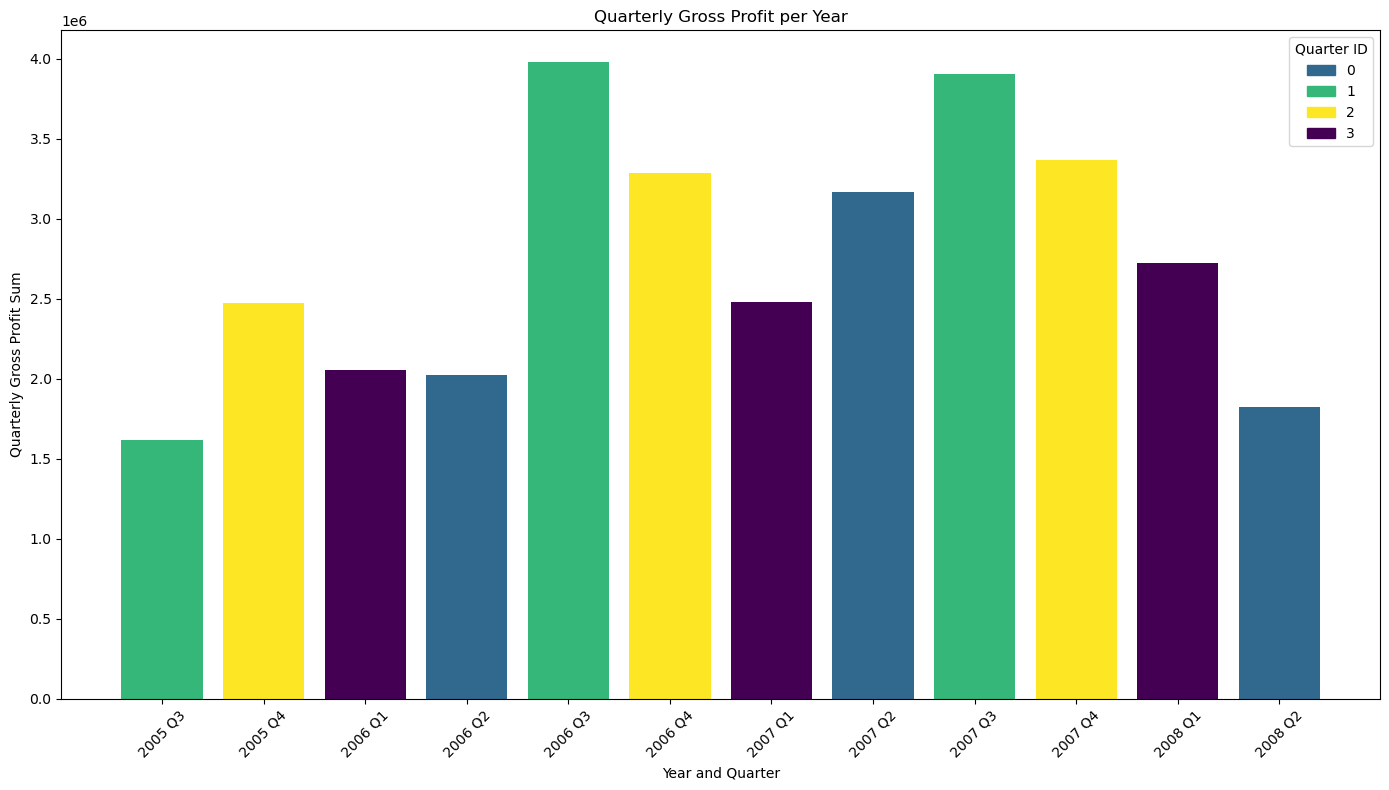

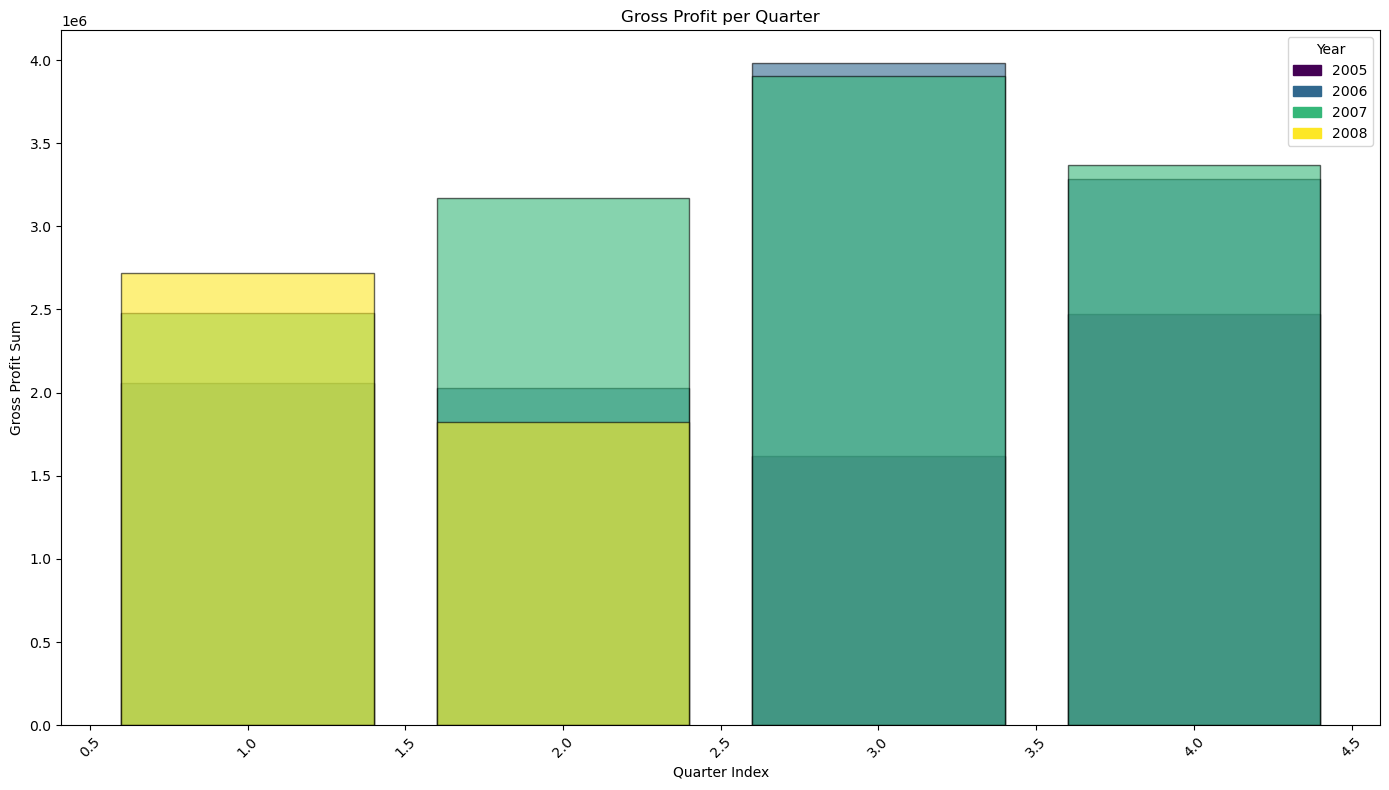

In [97]:
profit_per_quarter = time_series_per_quarter(sales_data,'Gross Profit');

Note: looking visually at patter it seems that maximum is at Q3 and minimum is in Q1, but we see that in last year it continues decreasing to Q2.

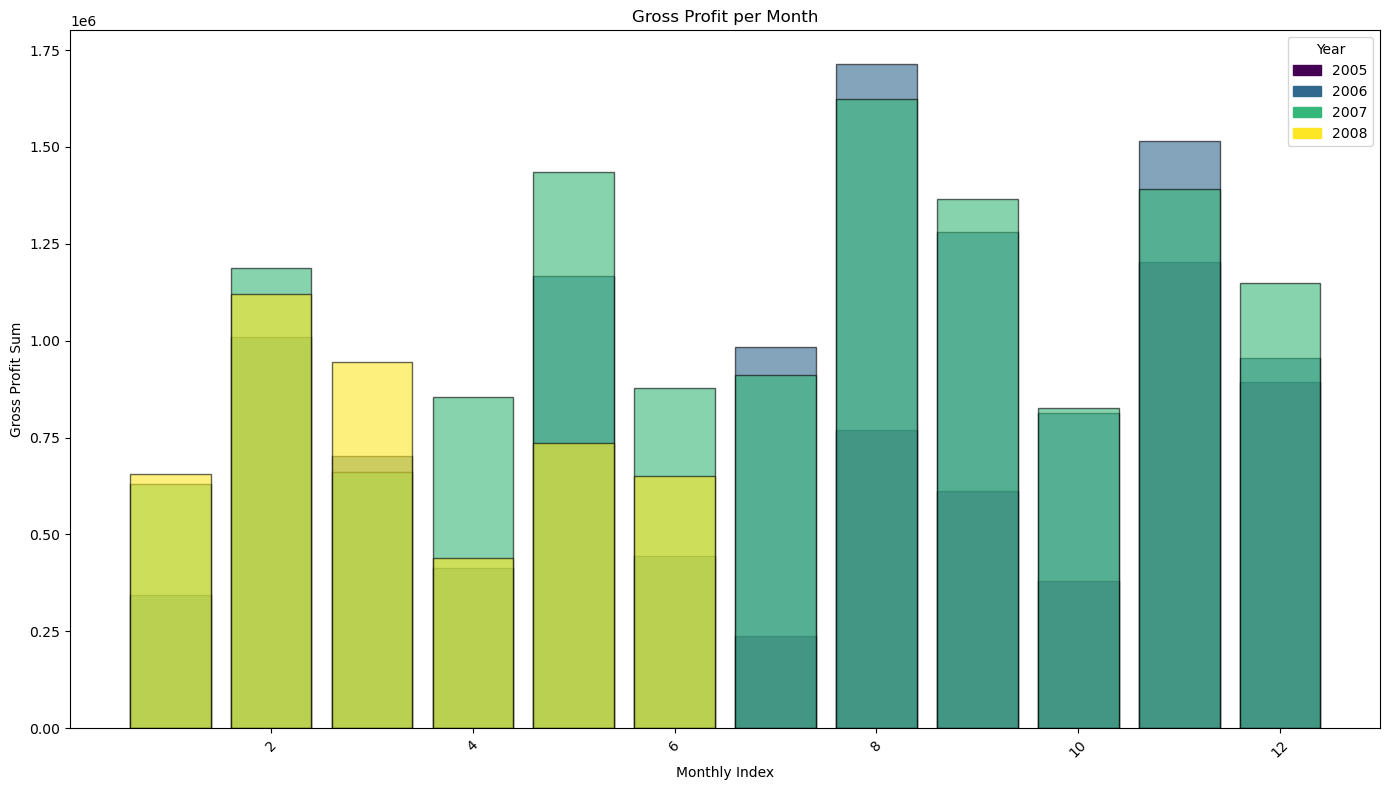

In [98]:
profit_per_month = time_series_per_month(sales_data, 'Gross Profit');

Note: Even thought there is no similarity in exact values per month, there is some seasonality in trend but last few months show significant decrease comparing to data trend.

## Revenue

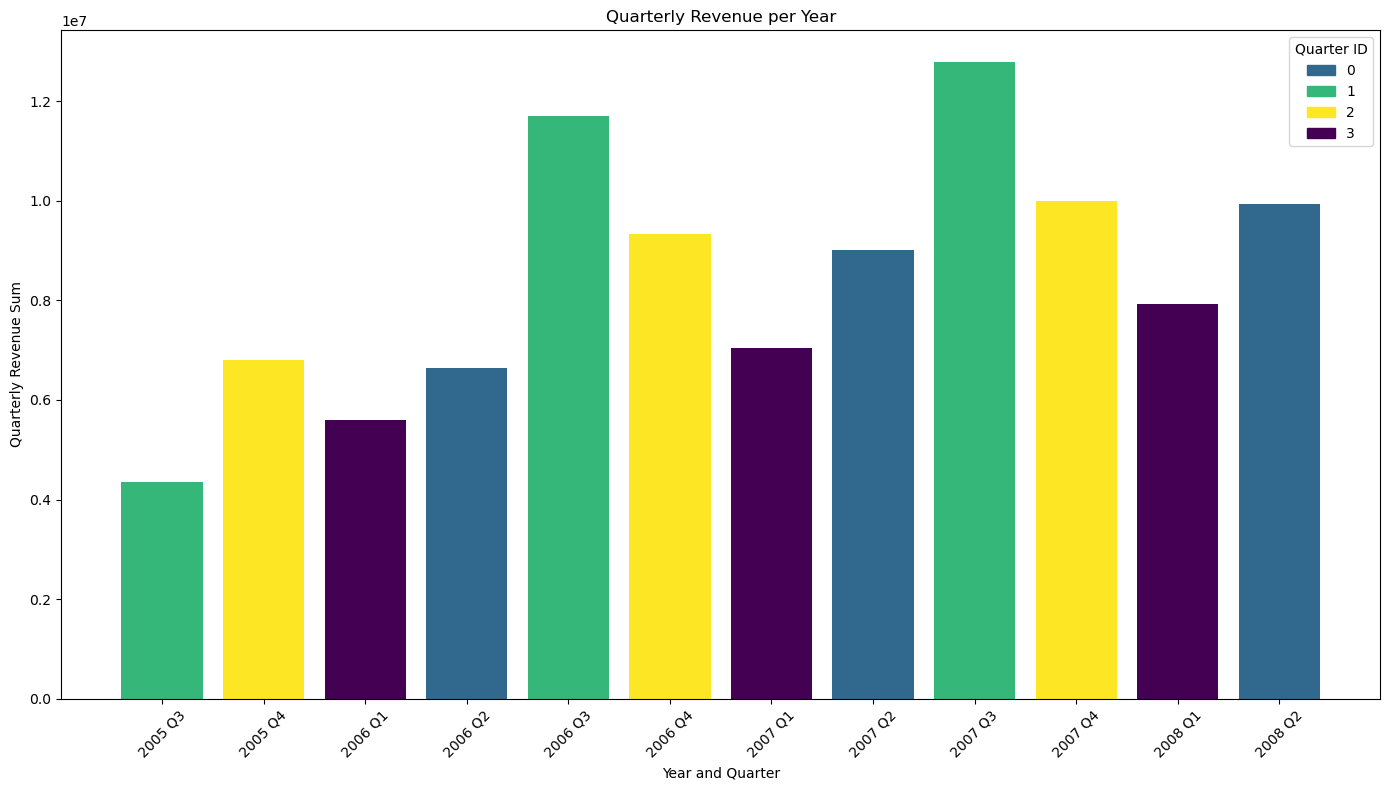

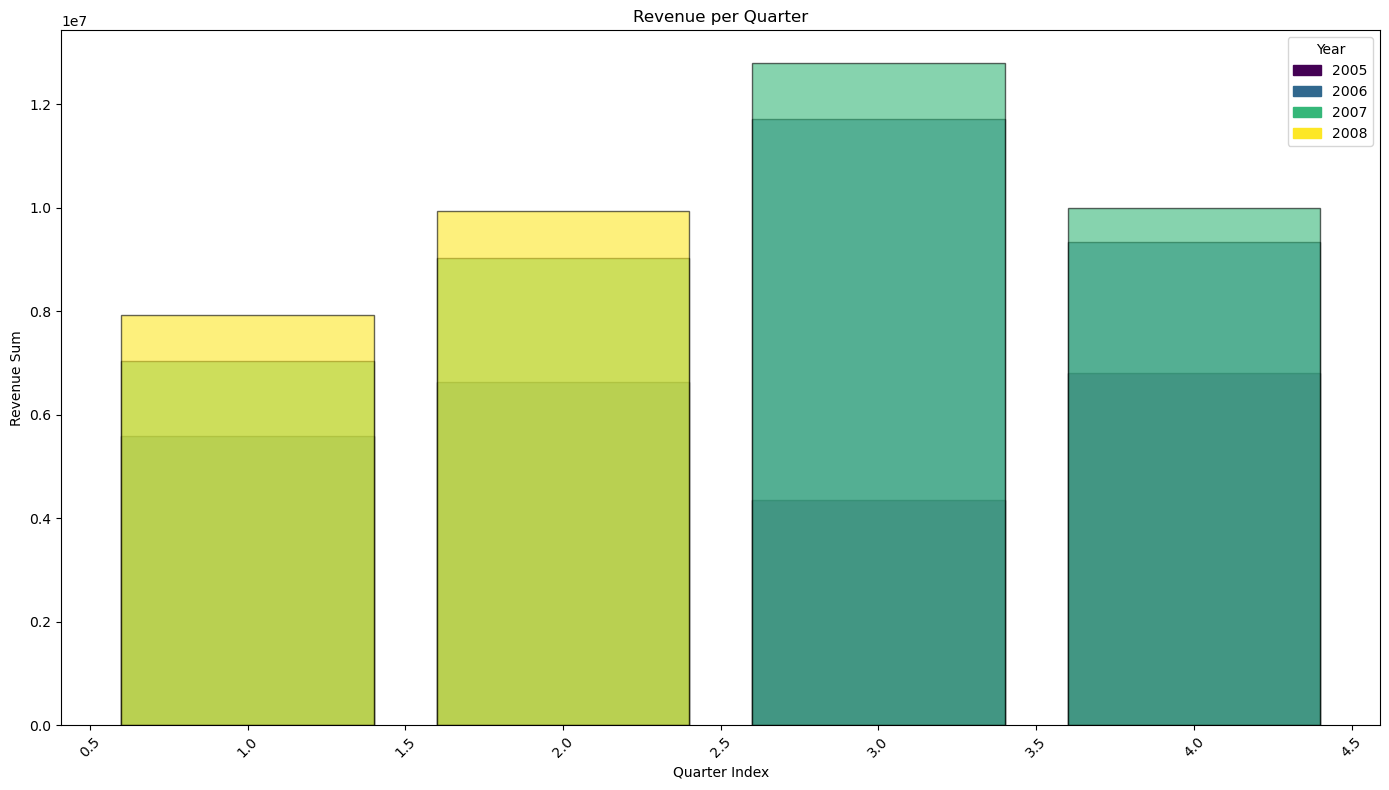

In [99]:
revenue_per_quarter = time_series_per_quarter(sales_data,'Revenue');

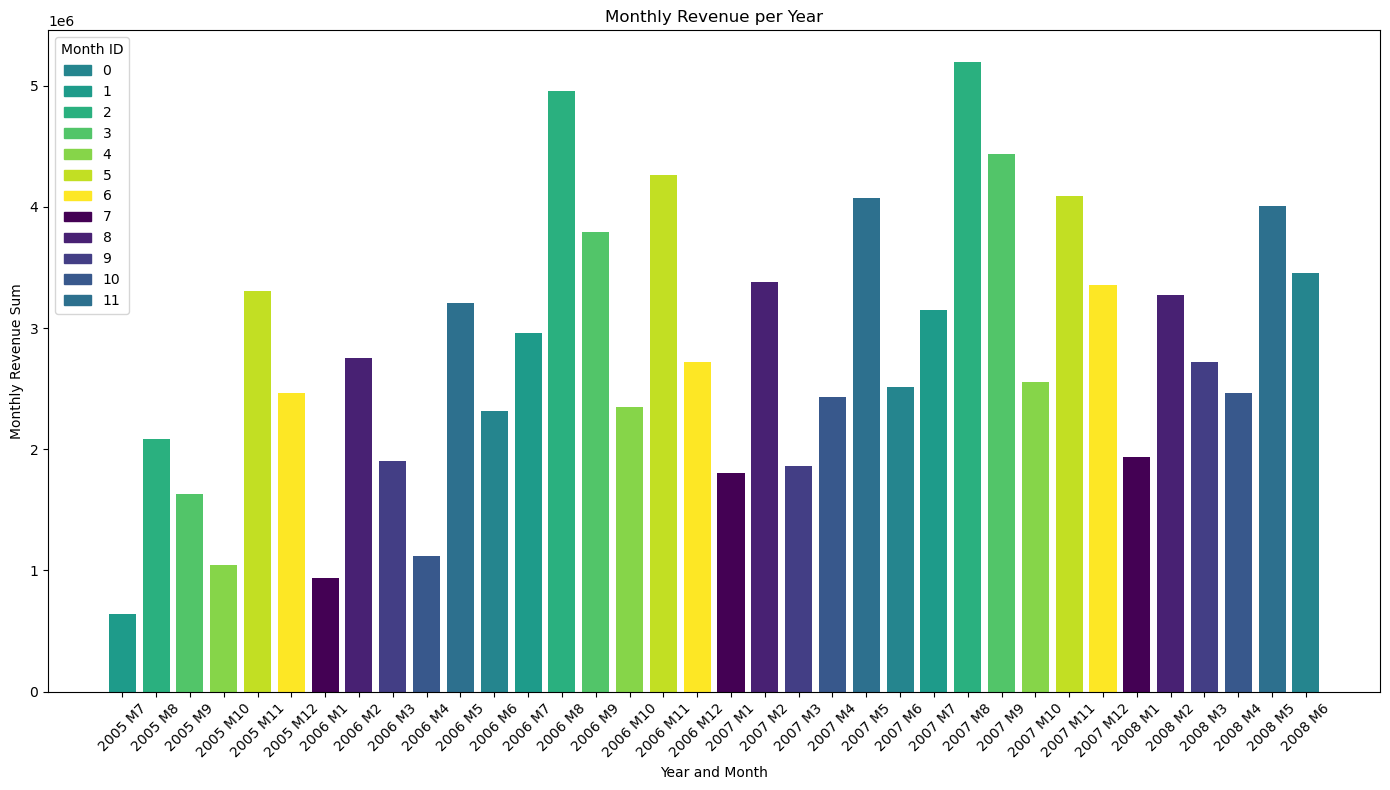

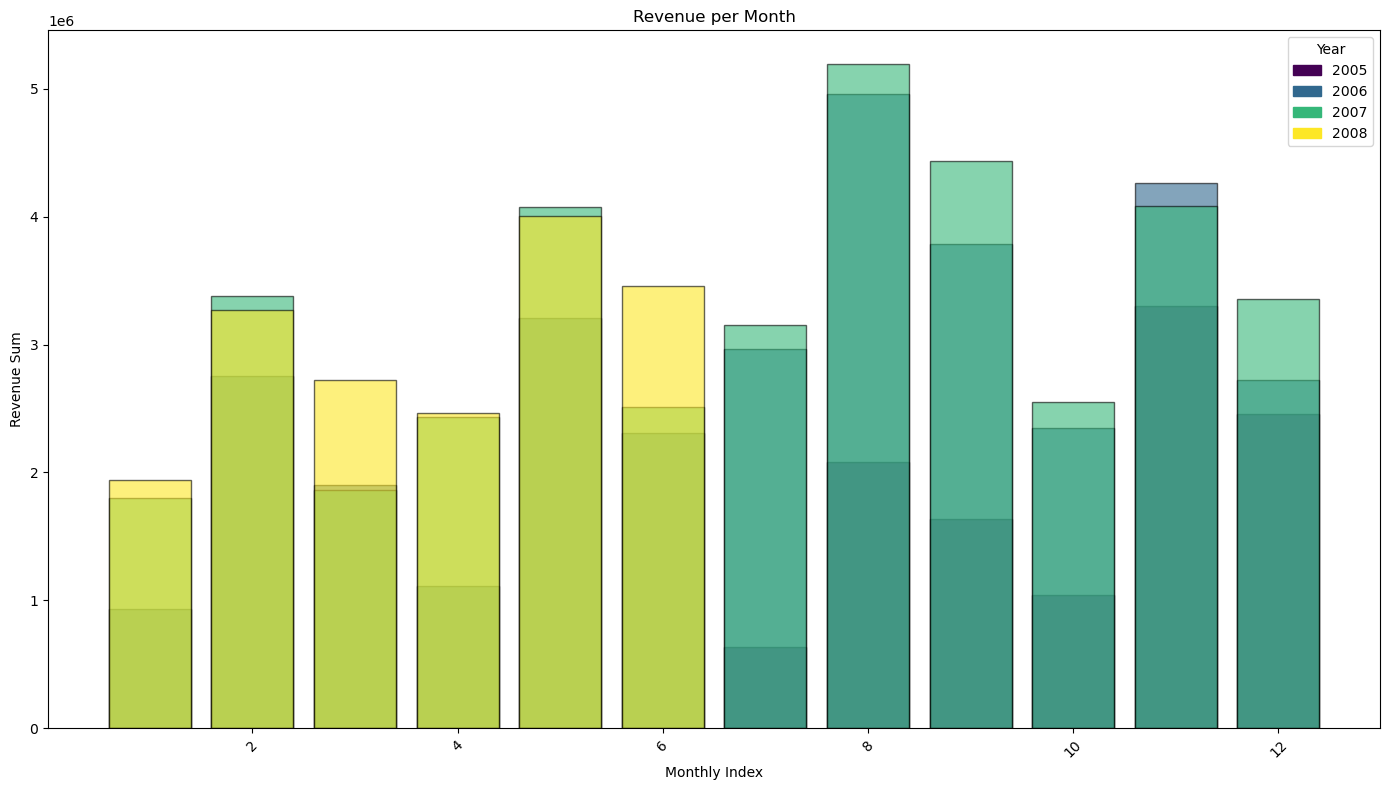

In [100]:
revenue_per_month = time_series_per_month(sales_data, 'Revenue');

It is similar as profit but note that there is no significant difference in trend of revenue -> whatever the cause is for profit decreease it seems that it didn't have impact on revenue. IT also seems there is correlation between revenues in months over years.

### Question: Can we solve the problem by increasing the unit price?

## COGS

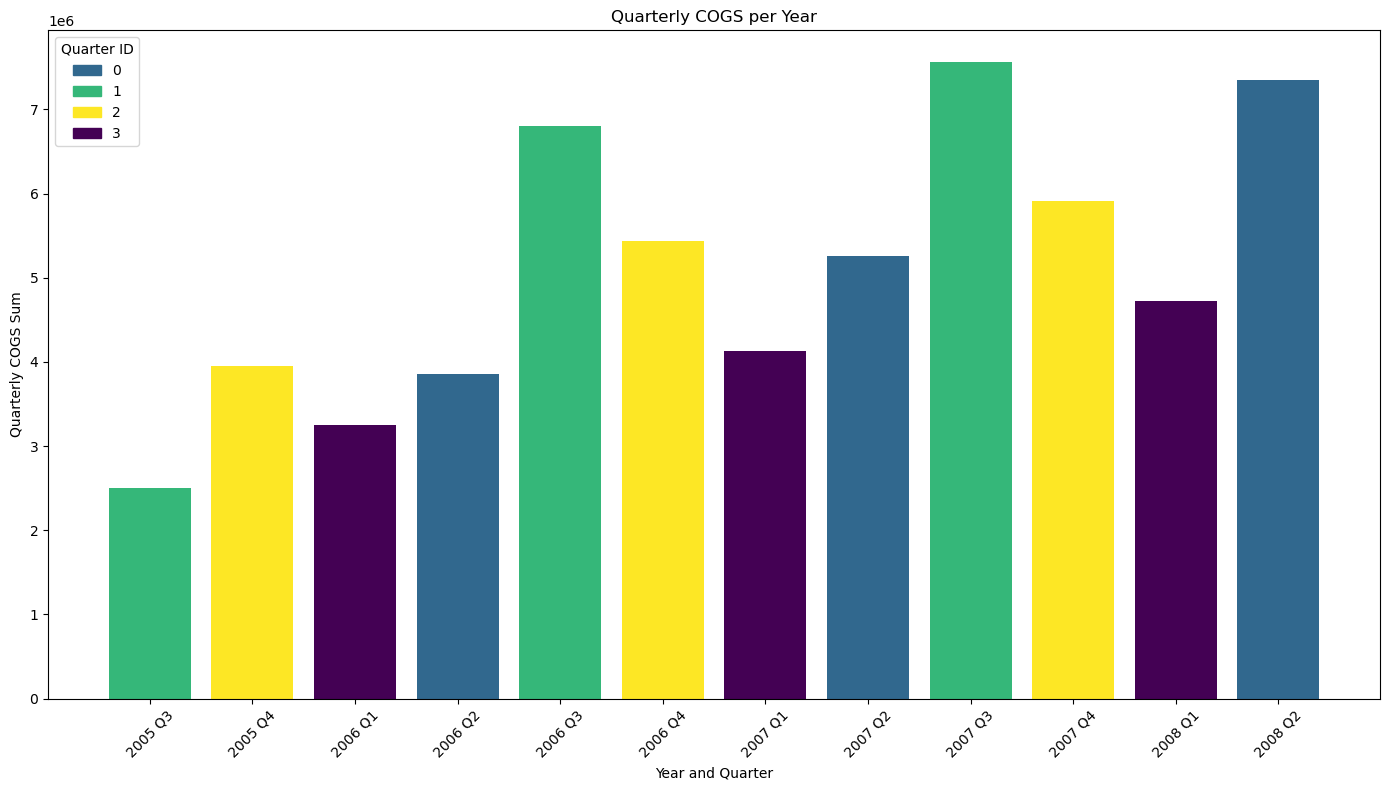

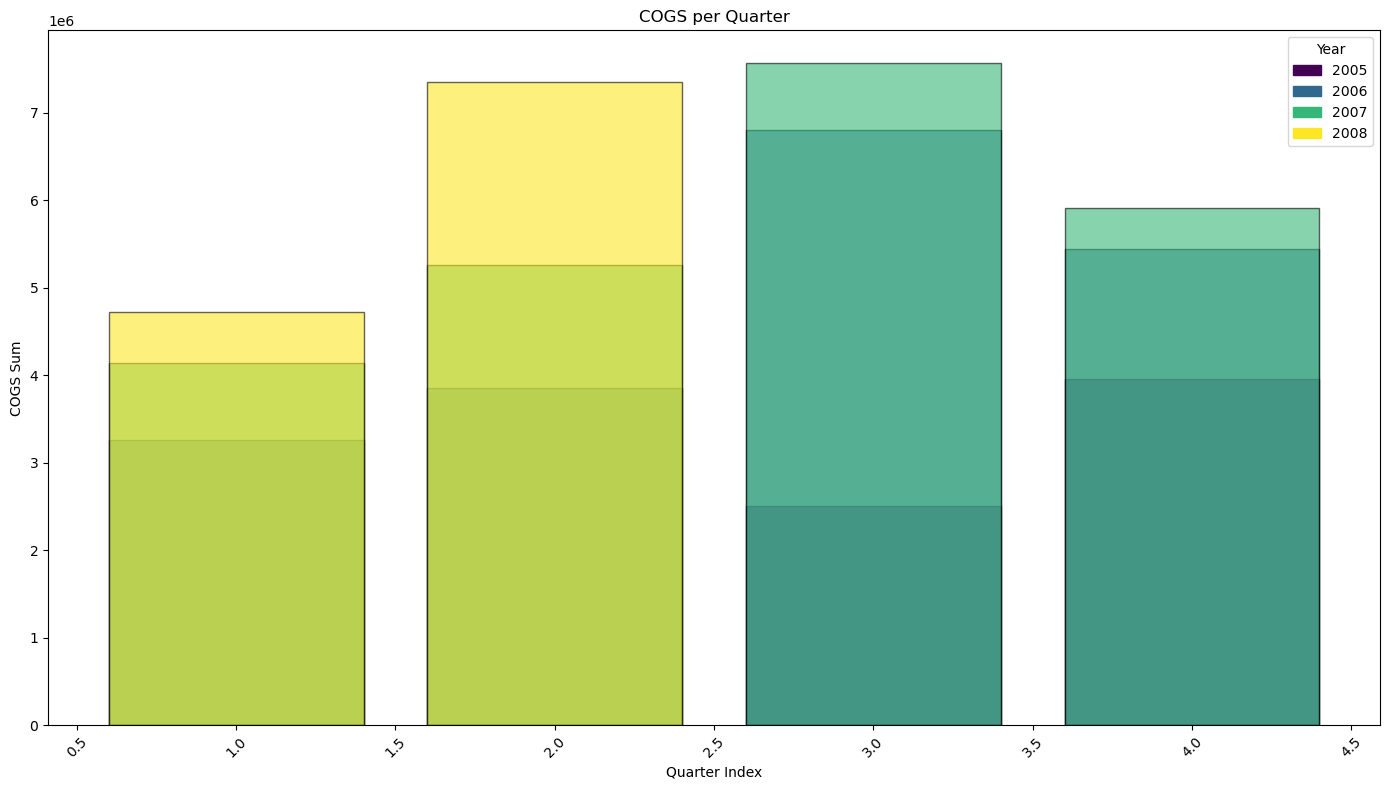

In [101]:
cogs_per_quarter = time_series_per_quarter(sales_data, 'COGS');

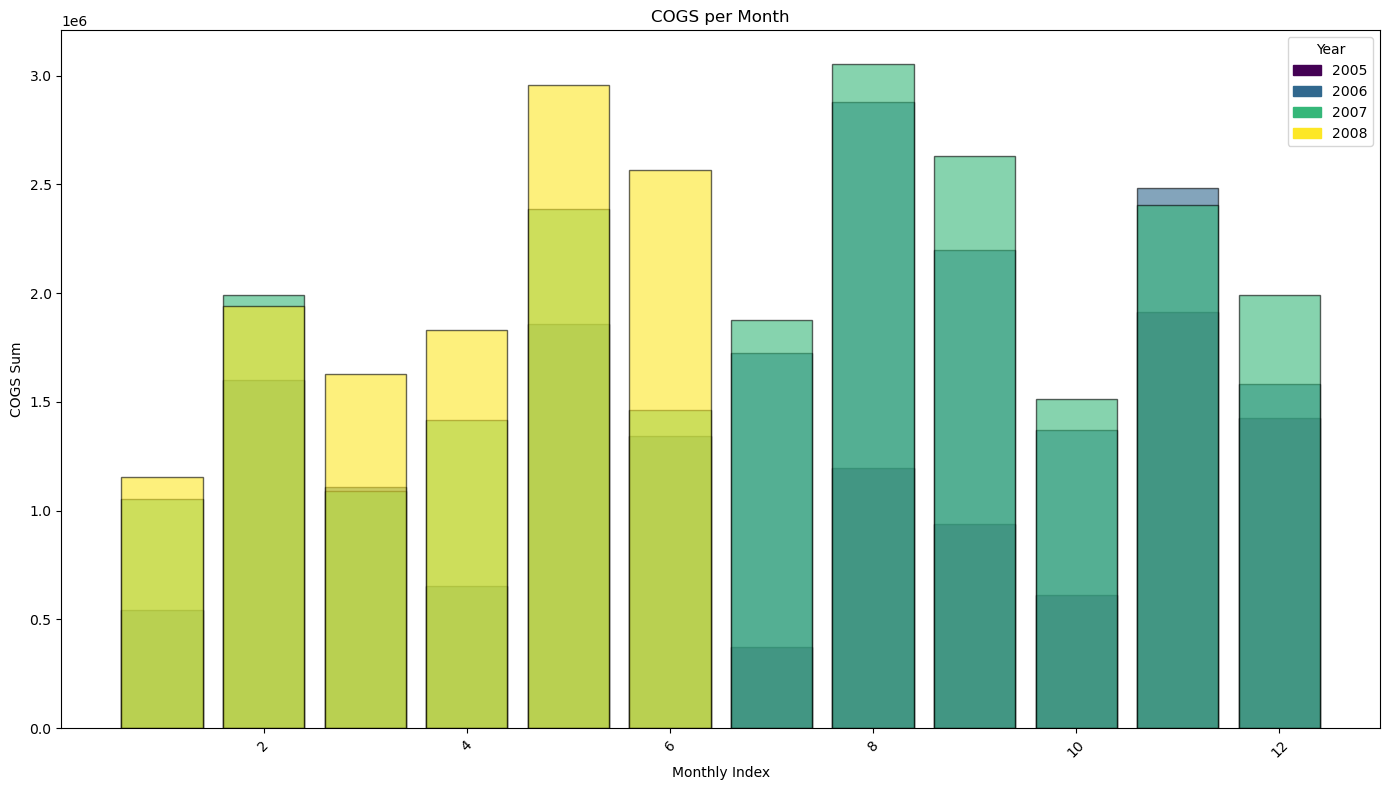

In [102]:
cogs_per_month = time_series_per_month(sales_data, 'COGS');

Note: Similar to Revenue we can see continuation in seasonality and correlation between months, but increase in COGS for last few months is much bigger than increase for revenue which can give us explanation for decreased profit

### Question: Did sudden rise in COGS caused lower profit?

## Freight cost

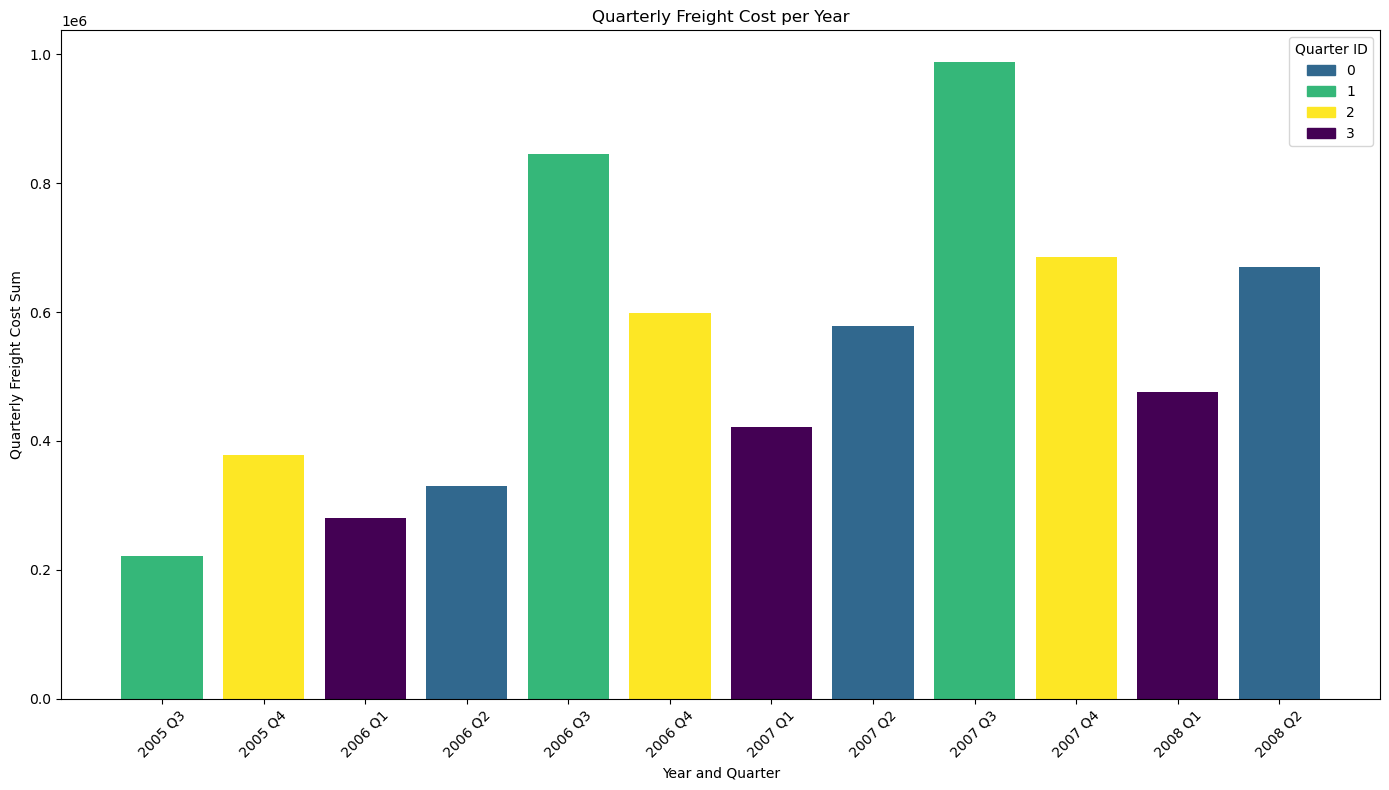

In [103]:
freight_cost_per_quarter = time_series_per_quarter(sales_data,'Freight Cost');

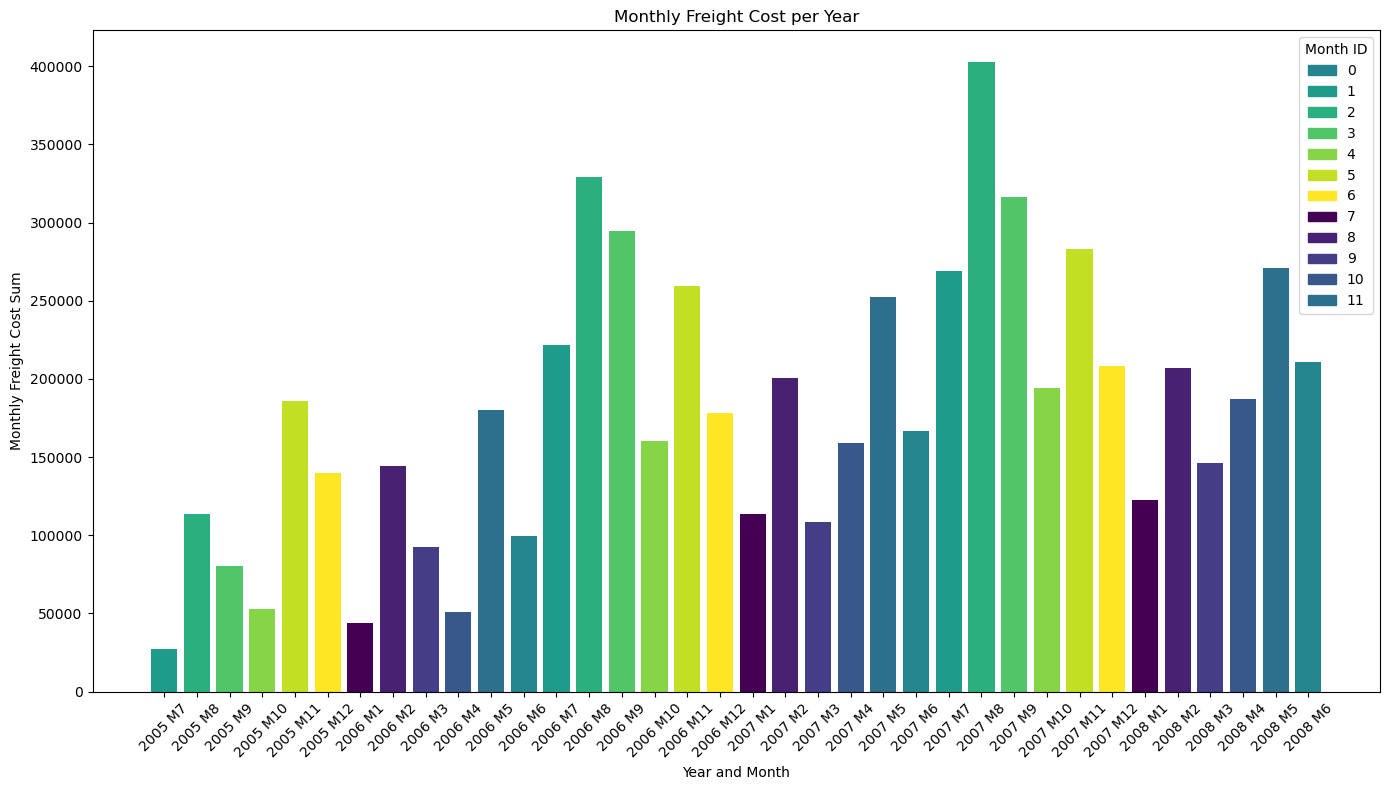

In [104]:
freight_cost_per_month = time_series_per_month(sales_data, 'Freight Cost');

Freight cost seems to behave similar to revenue and not to increase too much in comparison to revenue -> this feature don't seem liek cause for profit decrease.

## Quantity

In [105]:
quantity_per_quarter = time_series_per_quarter(sales_data,'Order Qty');

In [106]:
volume_per_month = time_series_per_month(sales_data, 'Order Qty');

Note: it seems that it behaves correctly in accordace with revenue, profit, freight_cost, but should be checked if this is the reason for bigger cogs.

## Discount

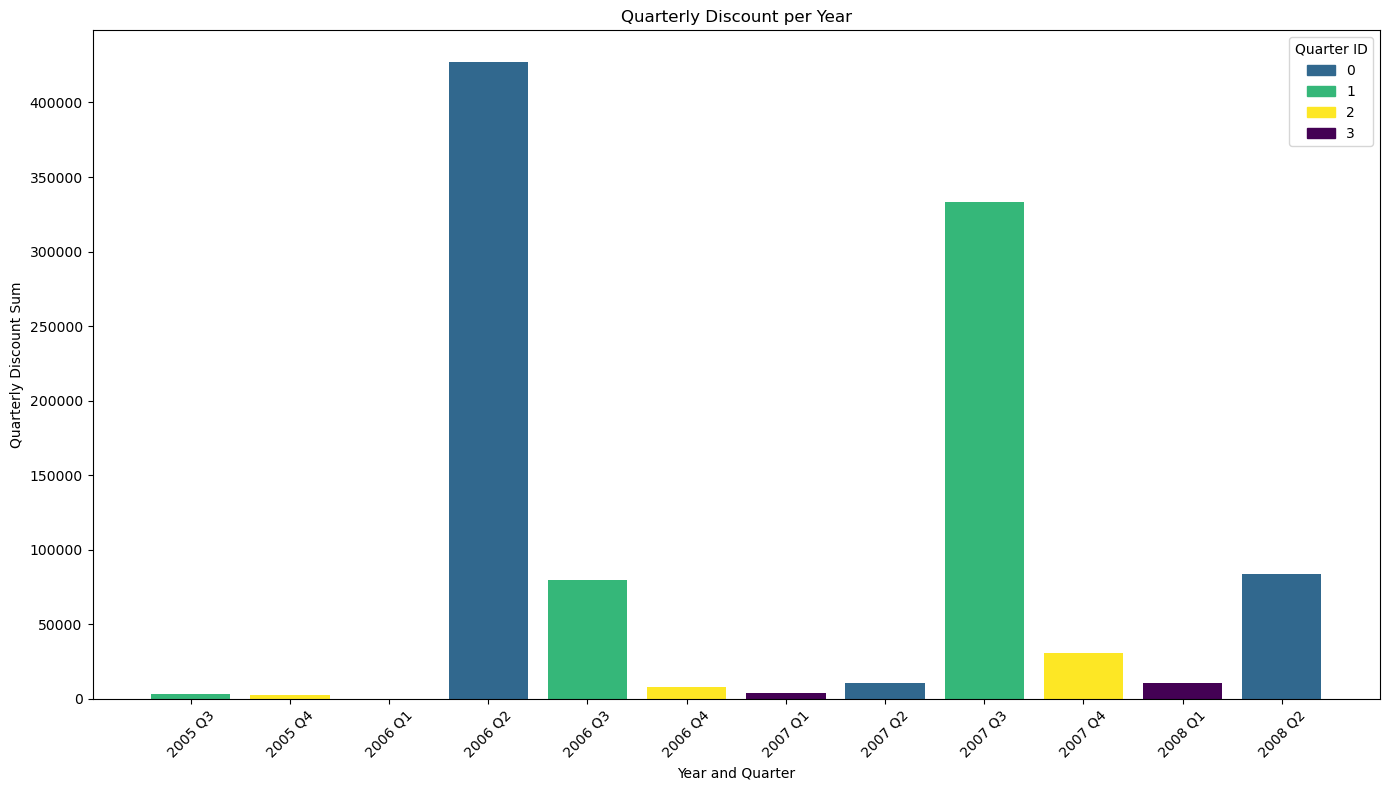

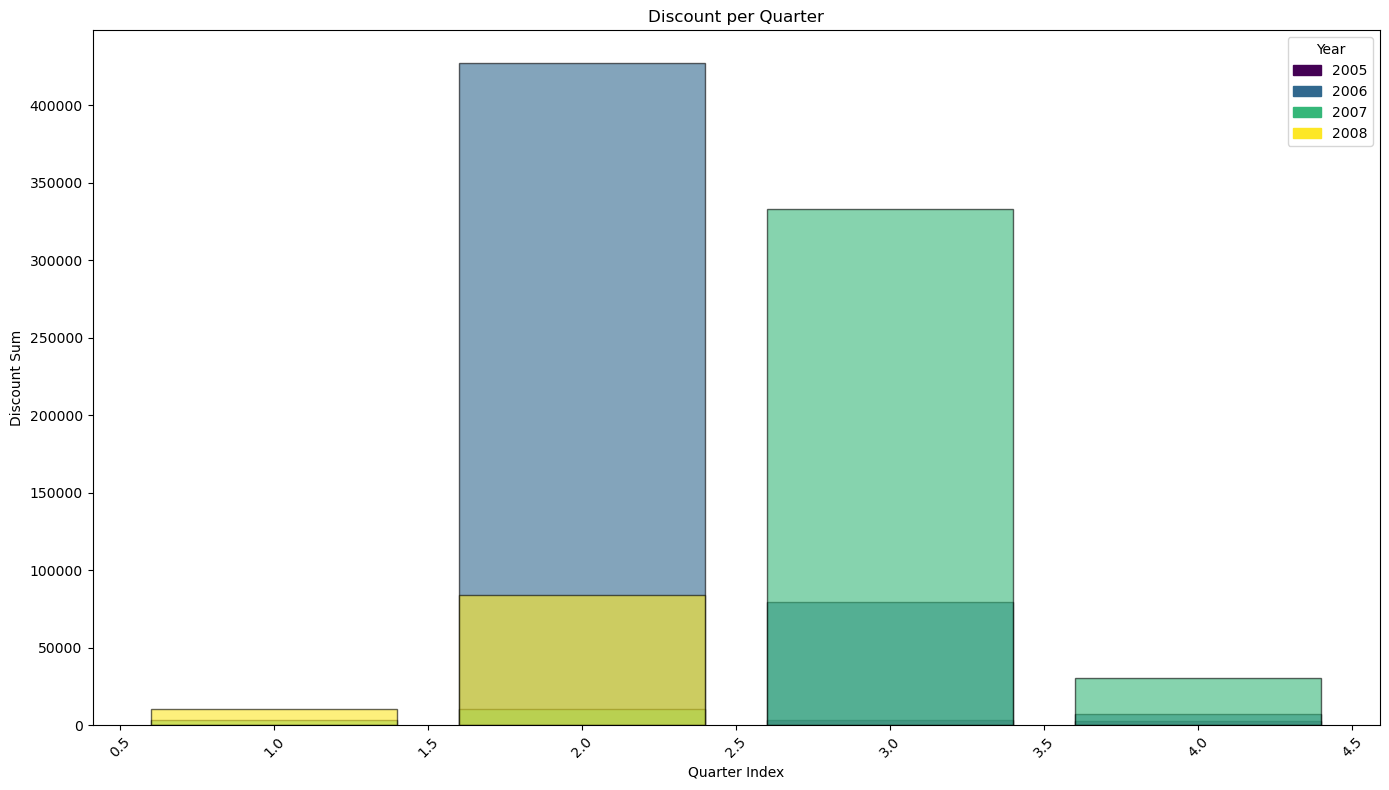

In [107]:
discount_per_quarter = time_series_per_quarter(sales_data,'Discount');

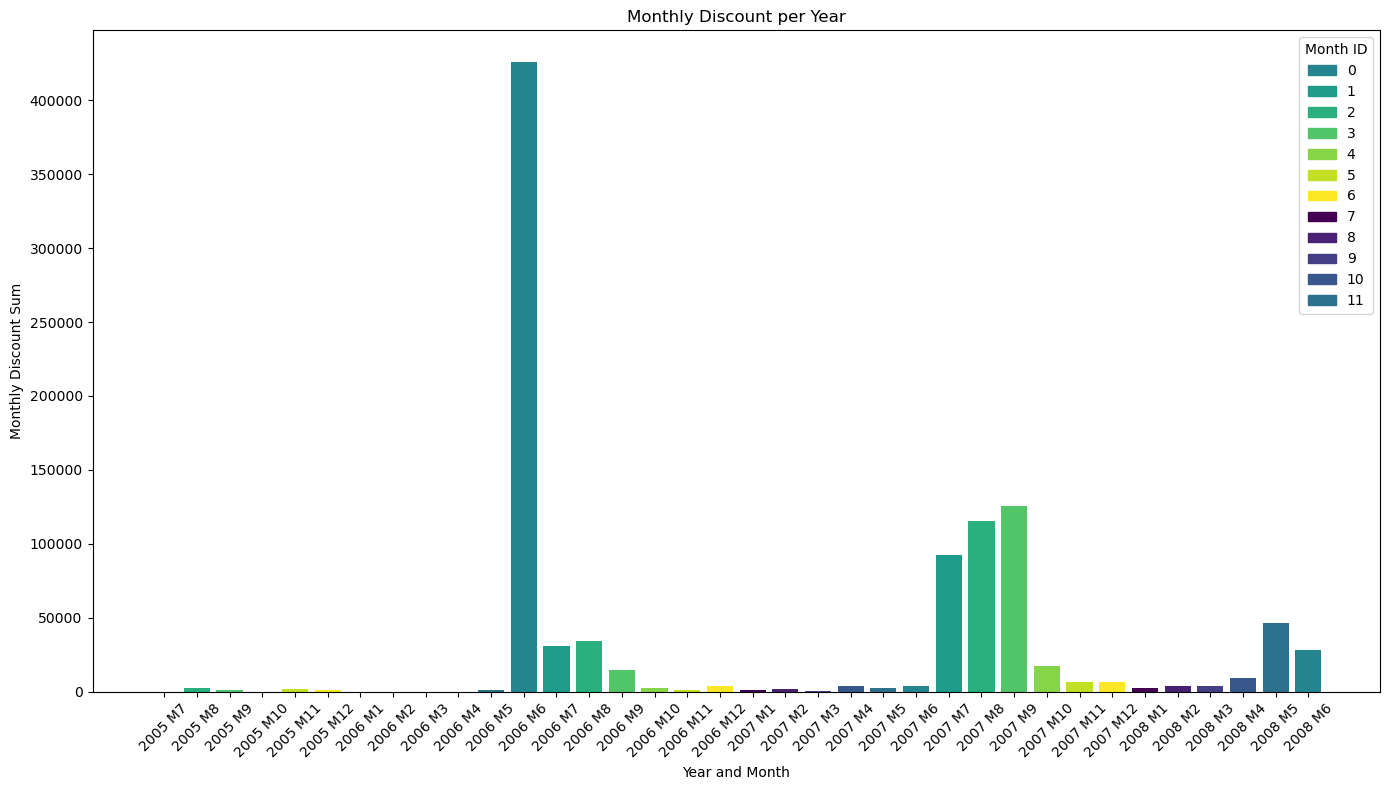

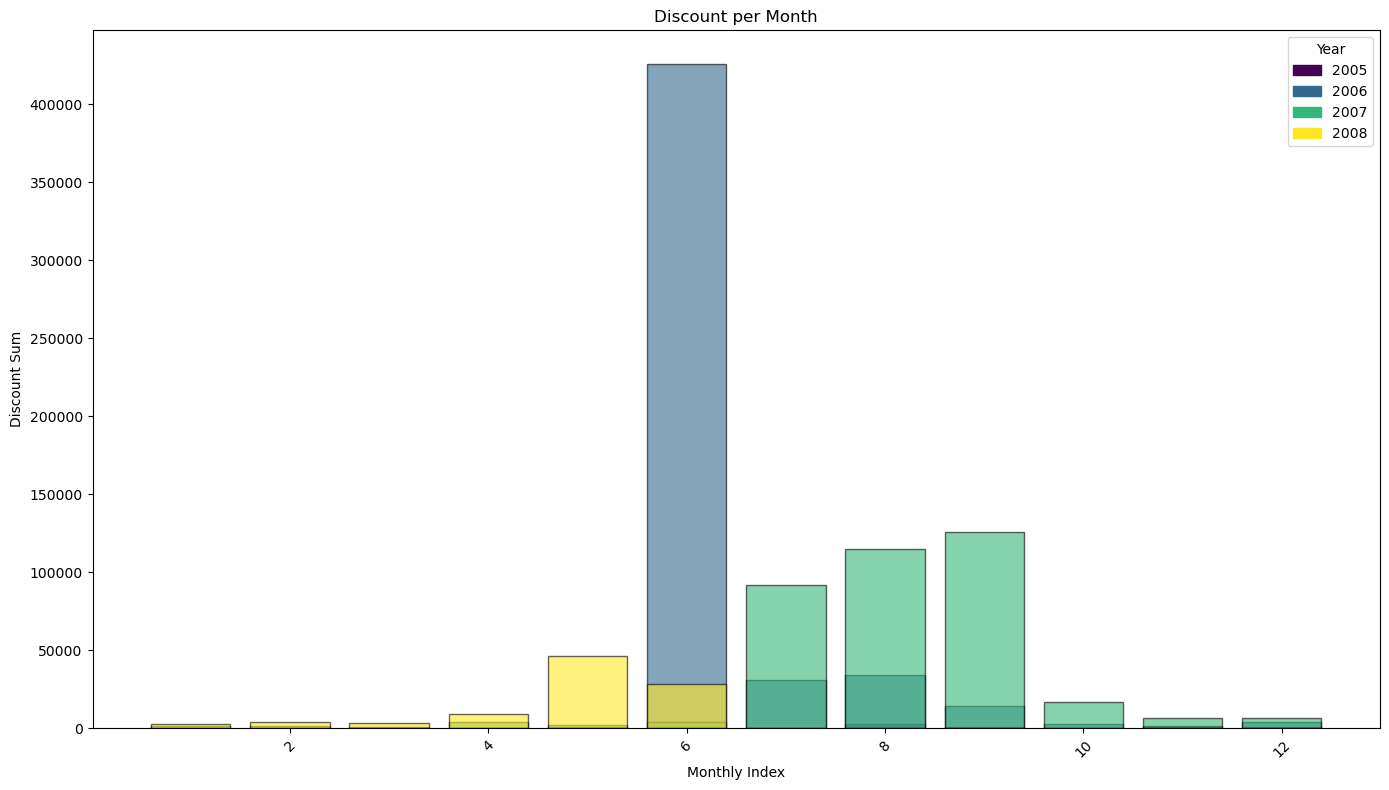

In [108]:
discount_per_month = time_series_per_month(sales_data, 'Discount');

### Question: is there some impact of sudden discounts on other features after the time of discount?

Note: Discounts are very rare but we can see two time periods where there was a discount -> we should analyse data before and after these two periods to see if discount has any impact on number of units sold. Since all data is much bigger since Q3 of the 2006 and there was really big discount in Q2 2006 it seems it could be factor for increasing all other data. 

## Profit margin

In [109]:
profit_per_quarter

Gross Profit Sum  Quarter  Year
Order Date                                 
2005-09-30      1.620204e+06        3  2005
2005-12-31      2.474913e+06        4  2005
2006-03-31      2.056169e+06        1  2006
2006-06-30      2.025466e+06        2  2006
2006-09-30      3.979615e+06        3  2006
2006-12-31      3.283686e+06        4  2006
2007-03-31      2.478926e+06        1  2007
2007-06-30      3.167350e+06        2  2007
2007-09-30      3.903005e+06        3  2007
2007-12-31      3.366166e+06        4  2007
2008-03-31      2.722269e+06        1  2008
2008-06-30      1.824843e+06        2  2008

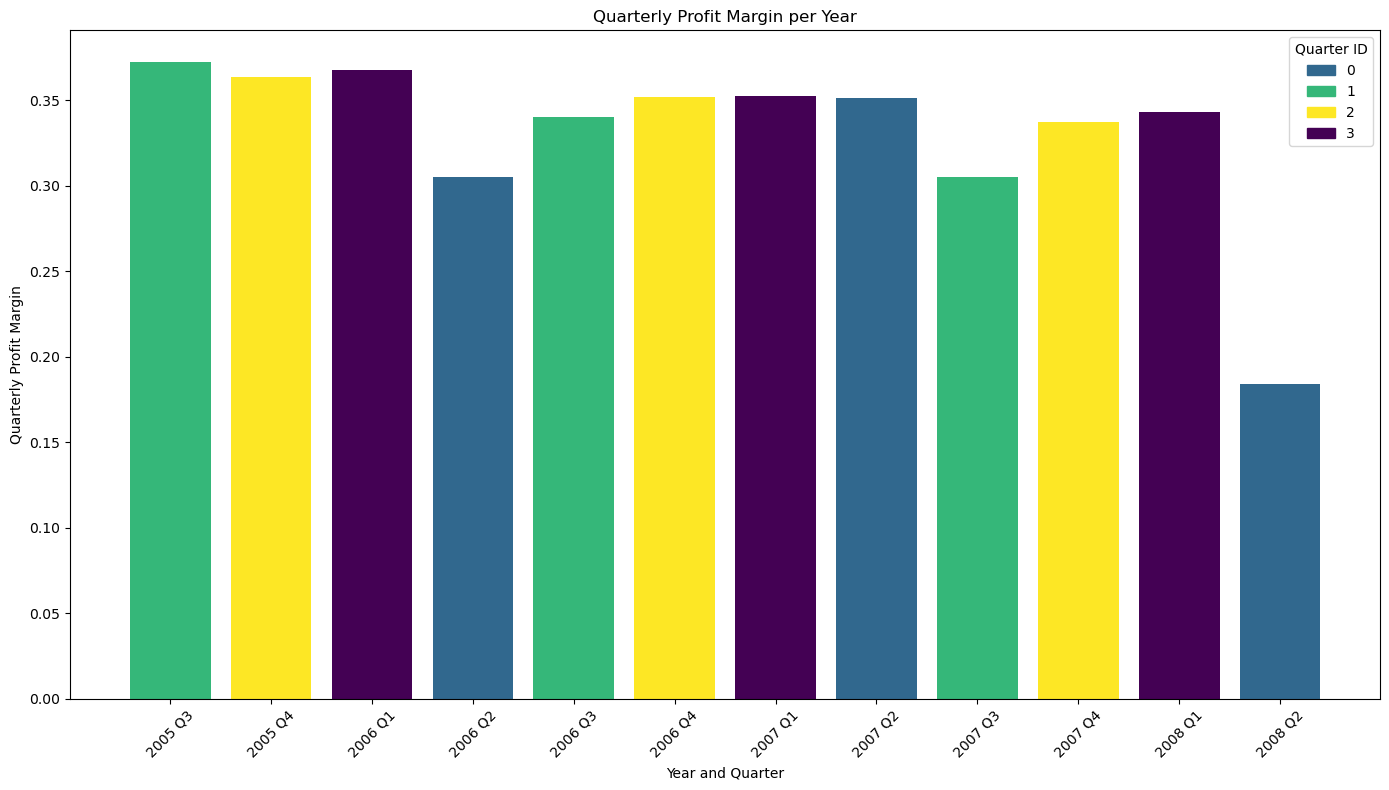

In [110]:
profit_margin_per_quarter = profit_per_quarter.copy(deep = True)
profit_margin_per_quarter['Profit Margin'] =profit_per_quarter['Gross Profit Sum']/revenue_per_quarter['Revenue Sum']
profit_margin_per_quarter.drop(columns = ['Gross Profit Sum'], inplace = True)

output_column = 'Profit Margin'
N_YEARS = 4
N_QUARTERS = 4
cmap = plt.get_cmap('viridis')
    
colors = cmap(np.linspace(0, 1, N_QUARTERS))
quarter_colors = colors[profit_margin_per_quarter['Quarter']-1]
# plot all quarters over time
plt.figure(figsize=(14,8))
plt.bar(profit_margin_per_quarter['Year'].astype(str) + ' Q' + profit_margin_per_quarter['Quarter'].astype(str),
            profit_margin_per_quarter[output_column], color = quarter_colors)
plt.title('Quarterly Profit Margin per Year')
plt.xlabel('Year and Quarter')
plt.ylabel('Quarterly ' + output_column)
plt.xticks(rotation=45)
legend_handles = [Patch(color=quarter_colors[quarter-1], label=str(quarter)) for quarter in range(4)]
plt.legend(handles=legend_handles, title='Quarter ID')
plt.tight_layout()
plt.show()

In [111]:
profit_margin_per_month = profit_per_month.copy(deep = True)
profit_margin_per_month['Profit Margin'] =profit_per_month['Gross Profit Sum']/revenue_per_month['Revenue Sum']
profit_margin_per_month.drop(columns = ['Gross Profit Sum'], inplace = True)

N_YEARS = 4
N_MONTHS = 12
cmap = plt.get_cmap('viridis')
    
colors = cmap(np.linspace(0, 1, N_MONTHS))
month_colors = colors[profit_margin_per_month['Month']-1]
# plot all months over time
plt.figure(figsize=(14,8))
plt.bar(profit_margin_per_month['Year'].astype(str) + ' M' + profit_margin_per_month['Month'].astype(str),
            profit_margin_per_month[output_column], color = month_colors)
plt.title('Monthly Profit Margin per Year')
plt.xlabel('Year and Month')
plt.ylabel('Monthly ' + output_column)
plt.xticks(rotation=45)
legend_handles = [Patch(color=month_colors[month-1], label=str(month)) for month in range(12)]
plt.legend(handles=legend_handles, title='Month ID')
plt.tight_layout()
plt.show()

Note: We can see sudden drop in profit margin in the month when sudden big discount happend and that there is a sudden drop in profit margin in last three months. Beside these outliers profit margin is pretty constant as expected.

## Join data

In [112]:
sales_per_quarter = profit_per_quarter.copy(deep = True)
sales_per_quarter = pd.merge(sales_per_quarter, revenue_per_quarter, on=[ 'Order Date','Quarter','Year'], how = 'outer')
sales_per_quarter = pd.merge(sales_per_quarter, discount_per_quarter, on=[ 'Order Date','Quarter','Year'], how = 'outer')
sales_per_quarter = pd.merge(sales_per_quarter, cogs_per_quarter, on=['Order Date','Quarter','Year'], how = 'outer')
sales_per_quarter = pd.merge(sales_per_quarter, freight_cost_per_quarter, on=['Order Date', 'Quarter','Year'], how = 'outer')
sales_per_quarter = pd.merge(sales_per_quarter, quantity_per_quarter, on=['Order Date', 'Quarter','Year'], how = 'outer')
sales_per_quarter = pd.merge(sales_per_quarter, profit_margin_per_quarter, on=['Order Date', 'Quarter','Year'], how = 'outer')
sales_per_quarter

Gross Profit Sum  Quarter  Year   Revenue Sum  Discount Sum  \
Order Date                                                                
2005-09-30      1.620204e+06        3  2005  4.353630e+06    3433.11500   
2005-12-31      2.474913e+06        4  2005  6.805578e+06    2434.68360   
2006-03-31      2.056169e+06        1  2006  5.592078e+06      11.68500   
2006-06-30      2.025466e+06        2  2006  6.635017e+06  427061.17470   
2006-09-30      3.979615e+06        3  2006  1.170983e+07   79462.58700   
2006-12-31      3.283686e+06        4  2006  9.329018e+06    7521.63570   
2007-03-31      2.478926e+06        1  2007  7.040146e+06    3648.04780   
2007-06-30      3.167350e+06        2  2007  9.017622e+06   10275.00055   
2007-09-30      3.903005e+06        3  2007  1.278542e+07  332979.04750   
2007-12-31      3.366166e+06        4  2007  9.992391e+06   30463.01220   
2008-03-31      2.722269e+06        1  2008  7.932156e+06   10361.60210   
2008-06-30      1.824843e+06        2  2008  9.928878e+06   83824.03200   

                COGS Sum  Freight Cost Sum  Order Qty Sum  Profit Margin  
Order Date                                                                
2005-09-30  2.508342e+06       221650.4139           3396       0.372150  
2005-12-31  3.950094e+06       378136.4767           5035       0.363659  
2006-03-31  3.255136e+06       280762.1310           3611       0.367693  
2006-06-30  3.852109e+06       330380.3697           5017       0.305269  
2006-09-30  6.804711e+06       846044.7814          19665       0.339852  
2006-12-31  5.439750e+06       598059.6553          14333       0.351986  
2007-03-31  4.135292e+06       422279.2000           9058       0.352113  
2007-06-30  5.261120e+06       578876.1136          14136       0.351240  
2007-09-30  7.561349e+06       988087.6210          24734       0.305270  
2007-12-31  5.910058e+06       685704.2090          17772       0.336873  
2008-03-31  4.723884e+06       475641.8298          11192       0.343194  
2008-06-30  7.350577e+06       669633.6827          17075       0.183791

In [113]:
sales_per_month = profit_per_month.copy(deep = True)
sales_per_month = pd.merge(sales_per_month, revenue_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month = pd.merge(sales_per_month, discount_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month = pd.merge(sales_per_month, cogs_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month = pd.merge(sales_per_month, freight_cost_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month = pd.merge(sales_per_month, volume_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month = pd.merge(sales_per_month, profit_margin_per_month, on=['Order Date', 'Month', 'Year'], how = 'outer')
sales_per_month

Gross Profit Sum  Month  Year  Revenue Sum  Discount Sum  \
Order Date                                                             
2005-07-31      2.385128e+05      7  2005   638871.550       0.00000   
2005-08-31      7.696477e+05      8  2005  2080426.540    2680.16720   
2005-09-30      6.120439e+05      9  2005  1634332.220     752.94780   
2005-10-31      3.787511e+05     10  2005  1041963.910      17.57500   
2005-11-30      1.203396e+06     11  2005  3302632.620    1569.85300   
2005-12-31      8.927659e+05     12  2005  2460980.970     847.25560   
2006-01-31      3.442218e+05      1  2006   933633.850       0.00000   
2006-02-28      1.008721e+06      2  2006  2754469.890      11.68500   
2006-03-31      7.032254e+05      3  2006  1903974.680       0.00000   
2006-04-30      4.135423e+05      4  2006  1116136.370      10.83000   
2006-05-31      1.167003e+06      5  2006  3207405.510    1035.79640   
2006-06-30      4.449207e+05      6  2006  2311475.200  426014.54830   
2006-07-31      9.843893e+05      7  2006  2962207.290   30691.10170   
2006-08-31      1.715039e+06      8  2006  4957940.980   34188.53880   
2006-09-30      1.280186e+06      9  2006  3789684.710   14582.94650   
2006-10-31      8.126767e+05     10  2006  2348663.190    2555.74510   
2006-11-30      1.515986e+06     11  2006  4260108.925     985.18890   
2006-12-31      9.550238e+05     12  2006  2720245.465    3980.70170   
2007-01-31      6.298193e+05      1  2007  1800402.130    1346.11470   
2007-02-28      1.187151e+06      2  2007  3380022.105    1719.10430   
2007-03-31      6.619559e+05      3  2007  1859721.770     582.82880   
2007-04-30      8.535213e+05      4  2007  2431772.135    4118.79890   
2007-05-31      1.435020e+06      5  2007  4074109.245    2157.30620   
2007-06-30      8.788096e+05      6  2007  2511740.380    3998.89545   
2007-07-31      9.125439e+05      7  2007  3151613.640   92139.67110   
2007-08-31      1.624069e+06      8  2007  5196945.770  115194.57830   
2007-09-30      1.366392e+06      9  2007  4436861.380  125644.79810   
2007-10-31      8.268366e+05     10  2007  2551214.530   17075.62470   
2007-11-30      1.390339e+06     11  2007  4086880.090    6765.77210   
2007-12-31      1.148990e+06     12  2007  3354296.610    6621.61540   
2008-01-31      6.568200e+05      1  2008  1937760.940    2727.60730   
2008-02-29      1.121404e+06      2  2008  3272950.590    4077.49550   
2008-03-31      9.440446e+05      3  2008  2721444.880    3556.49930   
2008-04-30      4.388618e+05      4  2008  2465597.750    9265.14590   
2008-05-31      7.348671e+05      5  2008  4007558.450   46140.67540   
2008-06-30      6.511139e+05      6  2008  3455721.700   28418.21070   

                COGS Sum  Freight Cost Sum  Order Qty Sum  Profit Margin  
Order Date                                                                
2005-07-31  3.731182e+05        27240.5180            594       0.373335  
2005-08-31  1.194329e+06       113769.7028           1566       0.369947  
2005-09-30  9.408952e+05        80640.1931           1236       0.374492  
2005-10-31  6.105701e+05        52625.1070            875       0.363497  
2005-11-30  1.911949e+06       185718.0509           2352       0.364375  
2005-12-31  1.427575e+06       139793.3188           1808       0.362768  
2006-01-31  5.456763e+05        43735.7572            613       0.368690  
2006-02-28  1.601503e+06       144233.5746           1696       0.366213  
2006-03-31  1.107956e+06        92792.7992           1302       0.369346  
2006-04-30  6.515870e+05        50996.2572            886       0.370512  
2006-05-31  1.859230e+06       180136.3442           2347       0.363846  
2006-06-30  1.341292e+06        99247.7683           1784       0.192483  
2006-07-31  1.725355e+06       221772.3967           5146       0.332316  
2006-08-31  2.879250e+06       329463.4140           8077       0.345918  
2006-09-30  2.200106e+06       294808.9707           6442       0.337808  


## Plot pairs

In [114]:
def plot_pairs(df):
    sns.pairplot(df)
    plt.title('Compare features plot')
    plt.show()

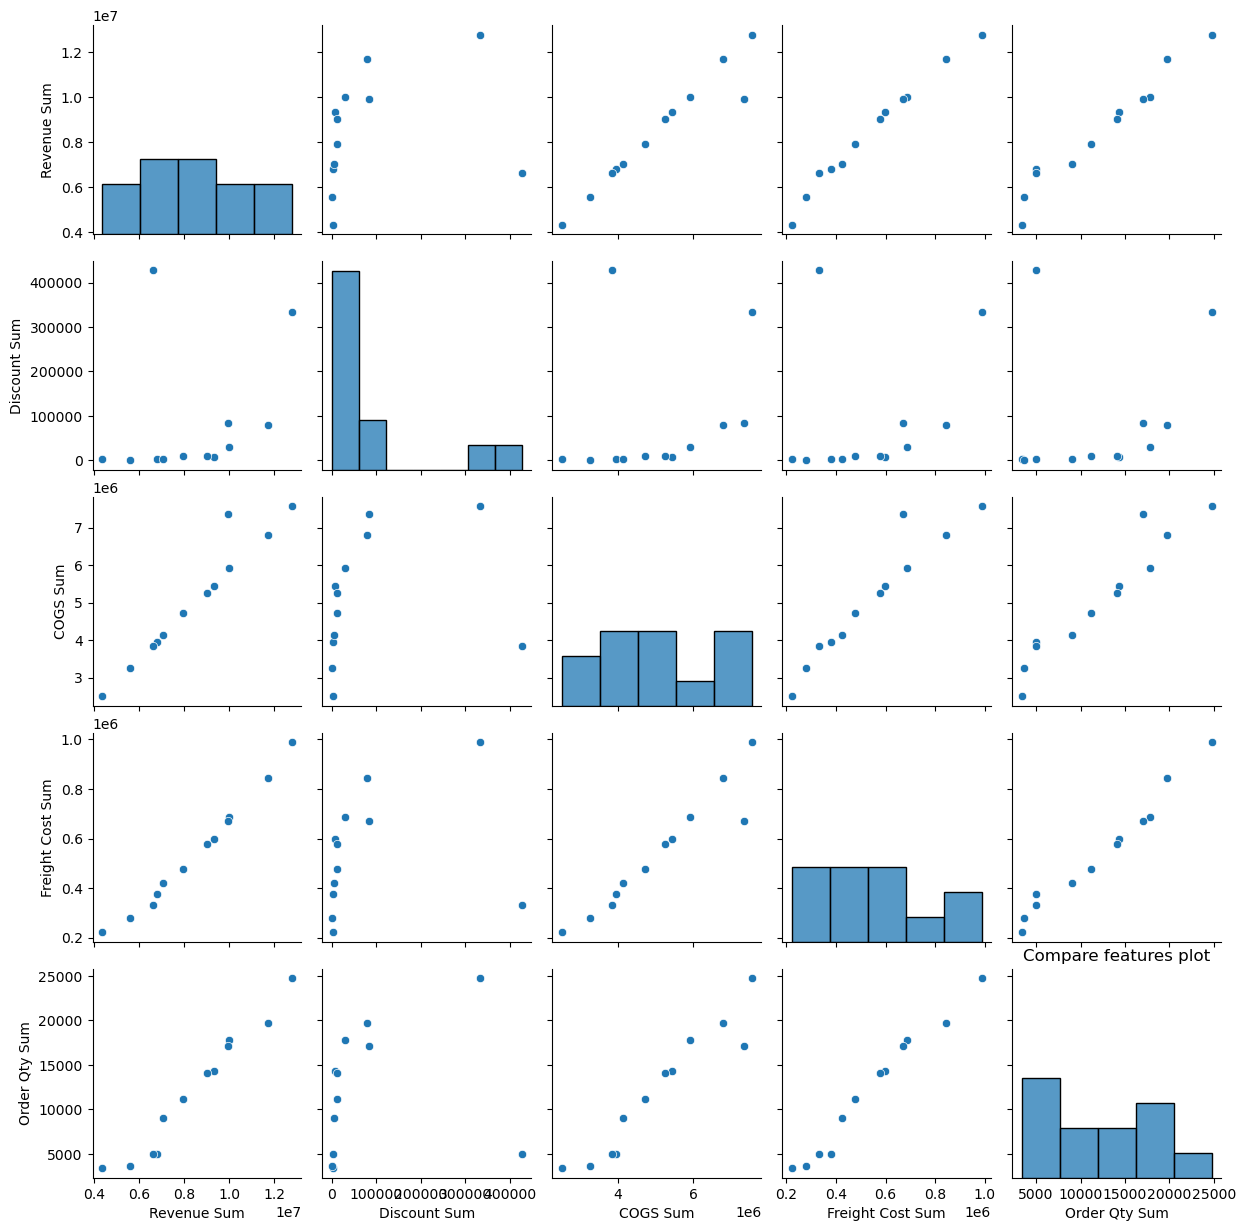

In [115]:
df = sales_per_quarter[[ 'Revenue Sum', 'Discount Sum','COGS Sum','Freight Cost Sum', 'Order Qty Sum']]
plot_pairs(df)

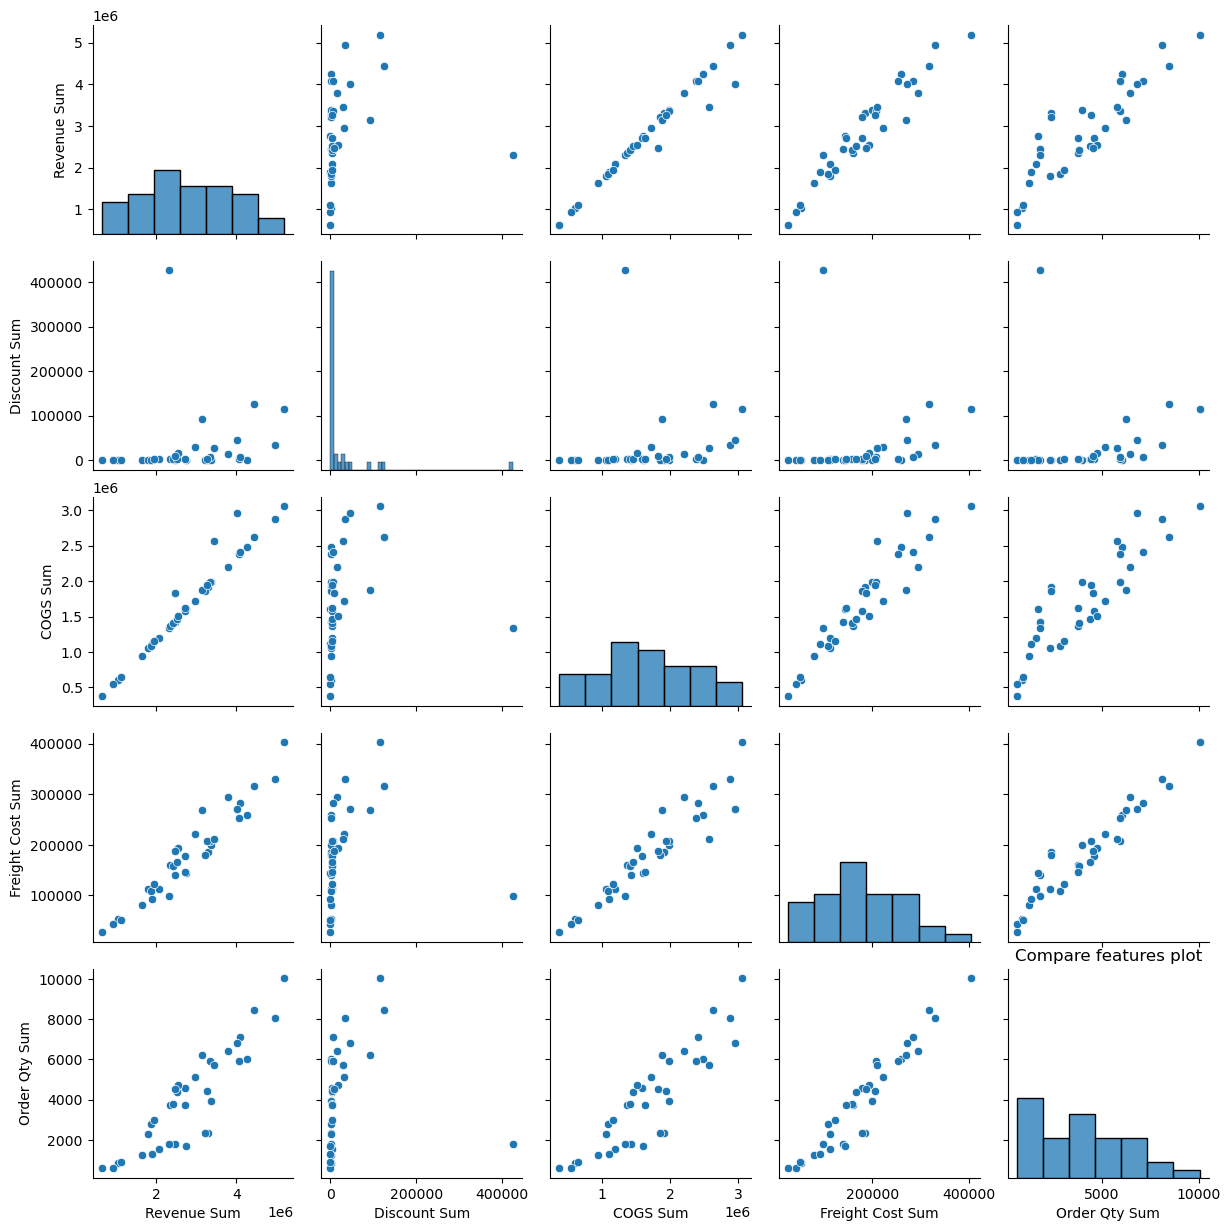

In [116]:
df = sales_per_month[[ 'Revenue Sum', 'Discount Sum','COGS Sum','Freight Cost Sum', 'Order Qty Sum']]
plot_pairs(df)

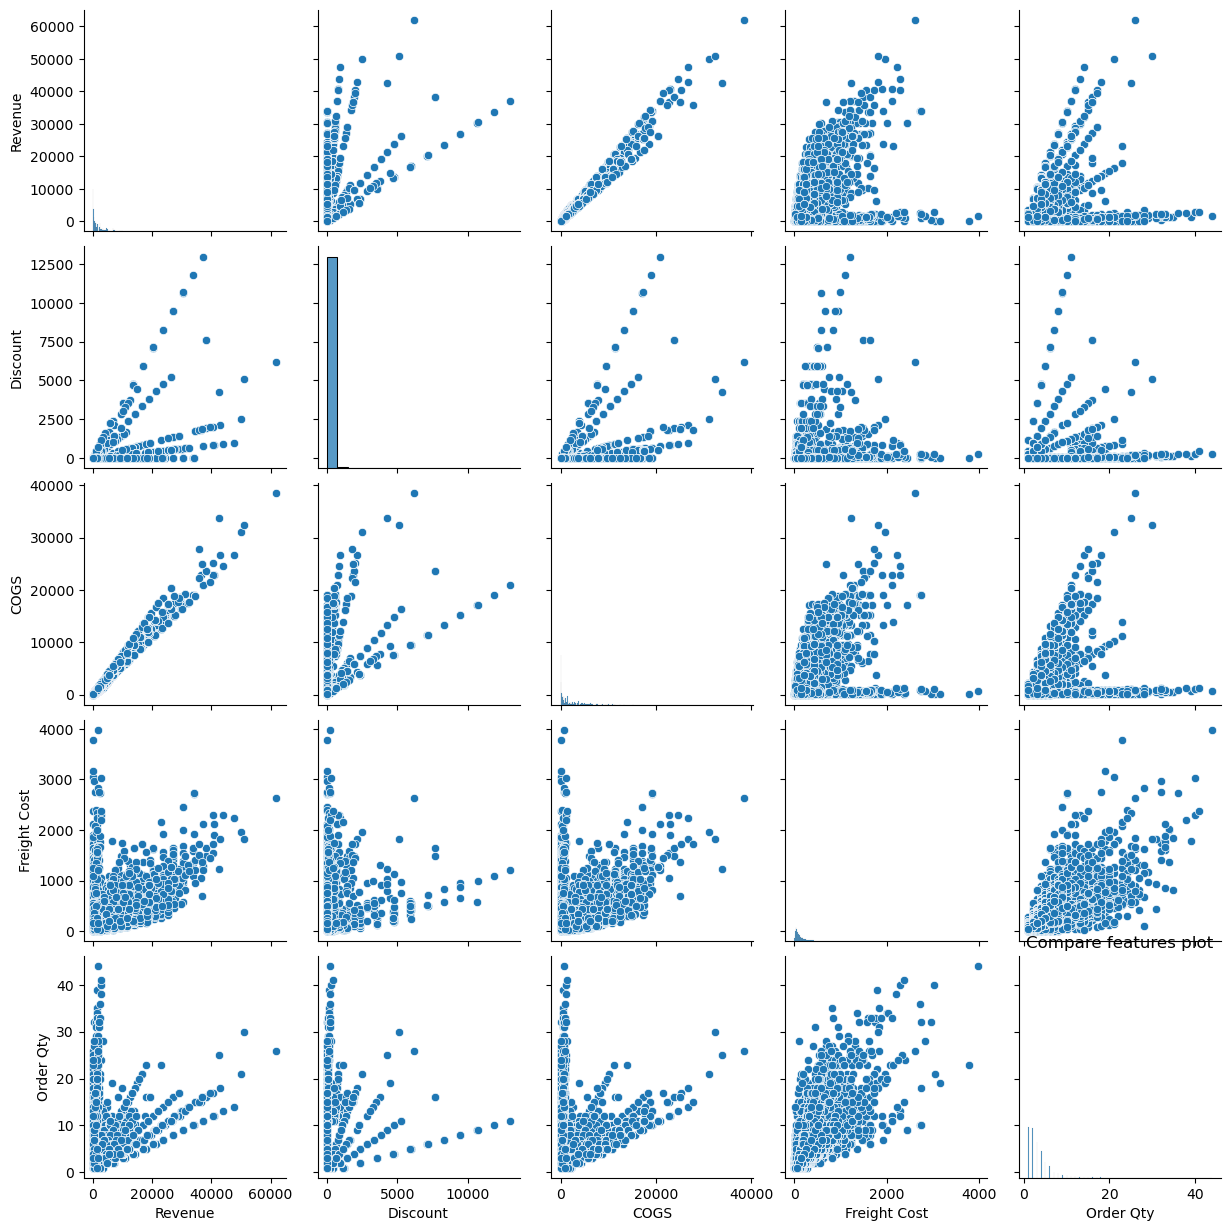

In [117]:
df = sales_data[[ 'Revenue', 'Discount', 'COGS','Freight Cost', 'Order Qty']]
plot_pairs(df)

Note: Relationship between features is pretty linear while relationship except discount which seems quadratic. Also, when we plot it for all data we see different lines showing up - it could be that these lines are different products or location(it makes sense that freight cost is dependent on location and COGS is dependent on product type), or some external factor for which we don't know, but by choosing slope of the line we can increase/decrease profit.

### Question: What are different lines?Can we increase the profit by choosing/emphasizing the line with biggest slope for some of the feature pairs?

## Calculate correlation between important features

In [118]:
def plot_kendall_correlation(df, name ):
    ''' 
        This function is used for plotting kenall  correlations for all dataframe columns and p-values for these correlations
        Inputs:
            df - dataframe for which we want to plot correlation
            name - name in the graphic title
    '''
    correlation_matrix = df.corr(method = 'kendall')
    
    p_values = pd.DataFrame(index=correlation_matrix.columns, columns=correlation_matrix.columns).astype('float')
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            kendall_corr, p_values.iloc[i, j] = kendalltau(df[col1], df[col2])

    fig, ax = plt.subplots(figsize=(16, 10), nrows = 2, ncols = 1)
    ax = ax.ravel()
    
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax = ax[0])
    ax[0].set_title('Kendall Correlation Matrix :'+ name)
    sns.heatmap(p_values, annot = True, cmap = 'coolwarm', ax = ax[1])
    ax[1].set_title('P values')

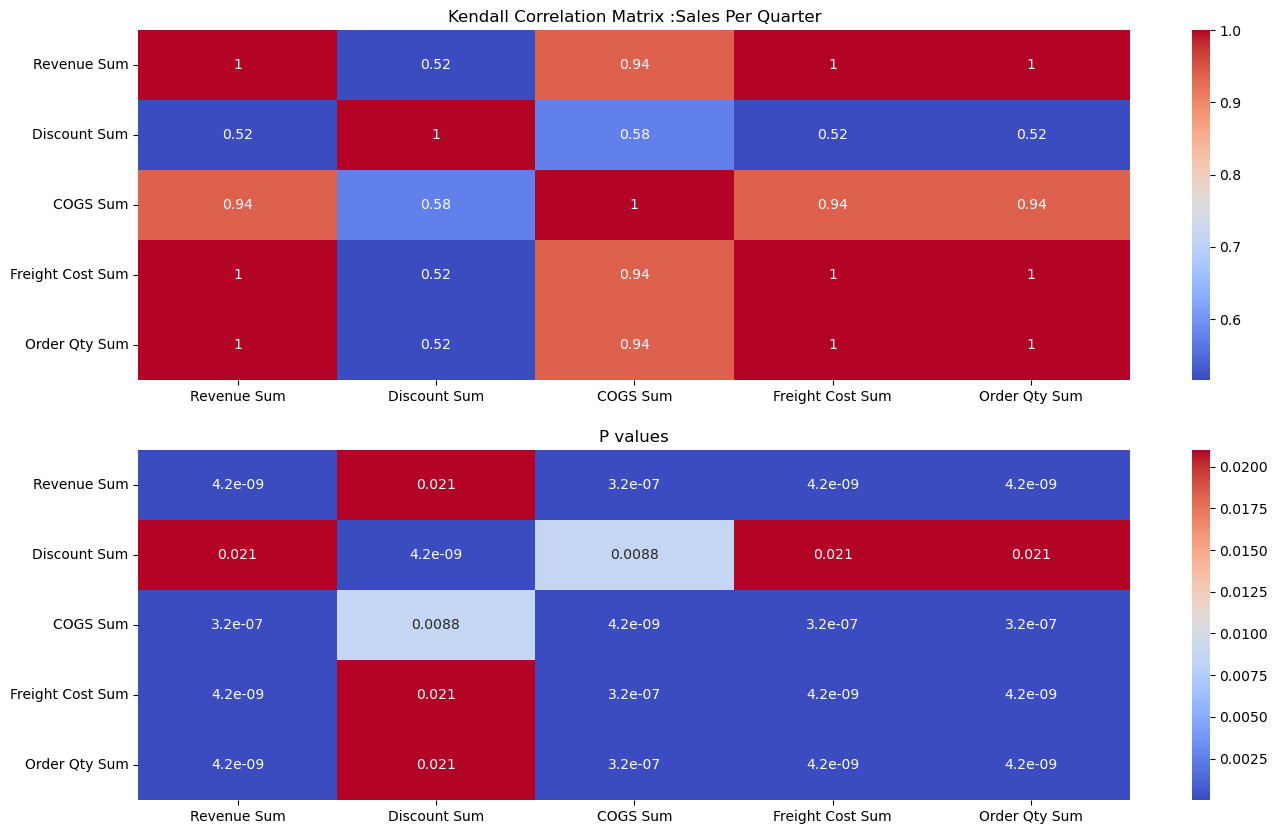

In [119]:
df = sales_per_quarter[[ 'Revenue Sum', 'Discount Sum','COGS Sum','Freight Cost Sum', 'Order Qty Sum']]
plot_kendall_correlation(df, 'Sales Per Quarter' )

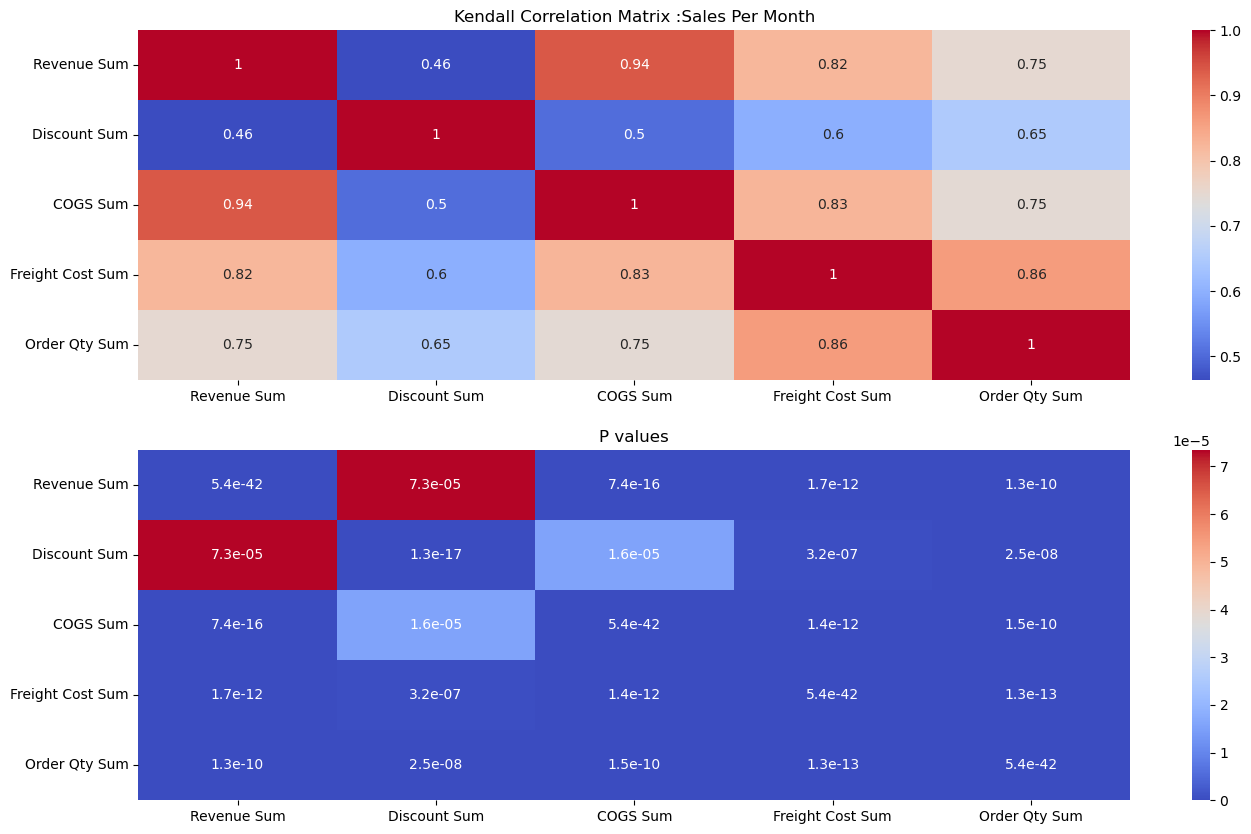

In [120]:
df = sales_per_month[['Revenue Sum', 'Discount Sum','COGS Sum','Freight Cost Sum', 'Order Qty Sum']]
plot_kendall_correlation(df, 'Sales Per Month' )

Note (last two images): All correlations are statistically significant. Correlations between all features are big enough(>0.7) except from correlations between discount and other features.(This does not imply independence, so there may be some non monotonic dependence that couldn't be catched by correlation)

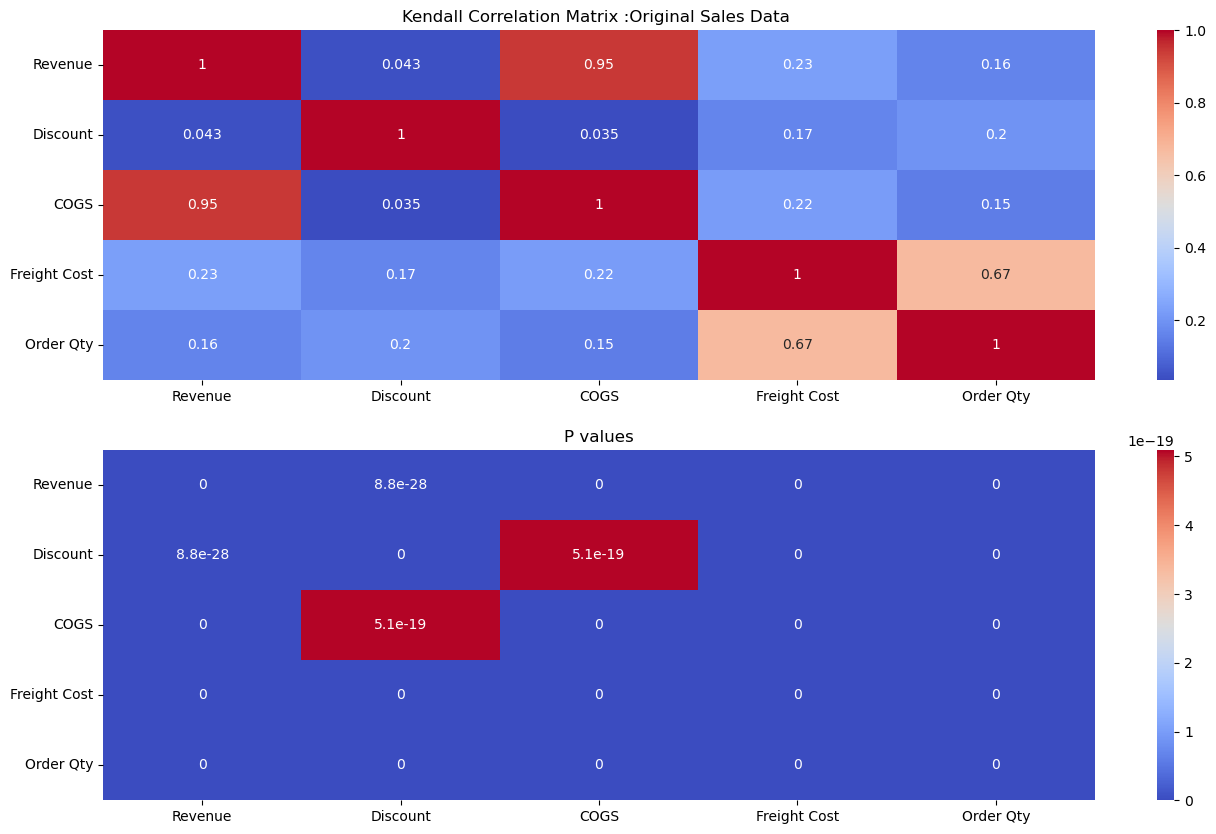

In [121]:
df = sales_data[['Revenue', 'Discount', 'COGS','Freight Cost', 'Order Qty']]

plot_kendall_correlation(df, 'Original Sales Data ' )

Note: when looking at all data there is correlation only between COGS and Revenue, reason for this is that, as discussed before, can be seen on pair plots - our model are too many lines so it is hard to catch one specific line. There is correlation for COGS and revenue just because these lines are so close that there is one line that can model them.

# Share of profits by Geography

In [122]:
def create_pie_plot(df, categories, value_column_name,n_rows, n_cols, top_k):
    ''' 
        This is the function for plotting pie plot for different categories on specified column value. 
        If there is more than top_k categories, we display only top_k categories which have most share
        Inputs:
            df - pandas dataframe for which we want to plot pieplot
            categories - categories for which we want to have segments on pie plot
            value_column_name - name of the column which value share is displayed
            n_rows - number of rows in subplot 
            n_cols - number of cols in subplot
            top_k - maximum number of categories to bi displayed
        Outputs:
            None  
    '''
    fig, ax = plt.subplots(figsize = (n_cols*12,n_rows*8), nrows = n_rows, ncols= n_cols)
    ax = ax.ravel()
    i = 0
    # go through all categories one by one and plot each of them on different subplot
    for category in categories:
        # group dataframe by category and sum it by value column
        grouped_df = df.groupby(category)[value_column_name].sum().reset_index()
        # sort values by value_column_name to display the biggest value shares first
        grouped_df = grouped_df.sort_values(value_column_name, ascending=False)
        # calculate if there are some other shares 
        others_profit = grouped_df.iloc[top_k:][value_column_name].sum()
        # extract top_k shares
        grouped_df = grouped_df.head(top_k)
        # insert row - other shares
        grouped_df.loc[len(grouped_df)] = ['Others', others_profit]
        # plot
        wedges, texts, autotexts = ax[i].pie(grouped_df[value_column_name], labels=grouped_df[category],
                                             autopct='%1.1f%%', startangle=140)
        ax[i].set_title(category)
        ax[i].axis('equal')
        i = i+1
    plt.suptitle(value_column_name+' Distribution for top '+ str(top_k))
    plt.show()

### Question: Can we lower freight cost by opening new store?
### Question: Can we increase quantity by opening new store?

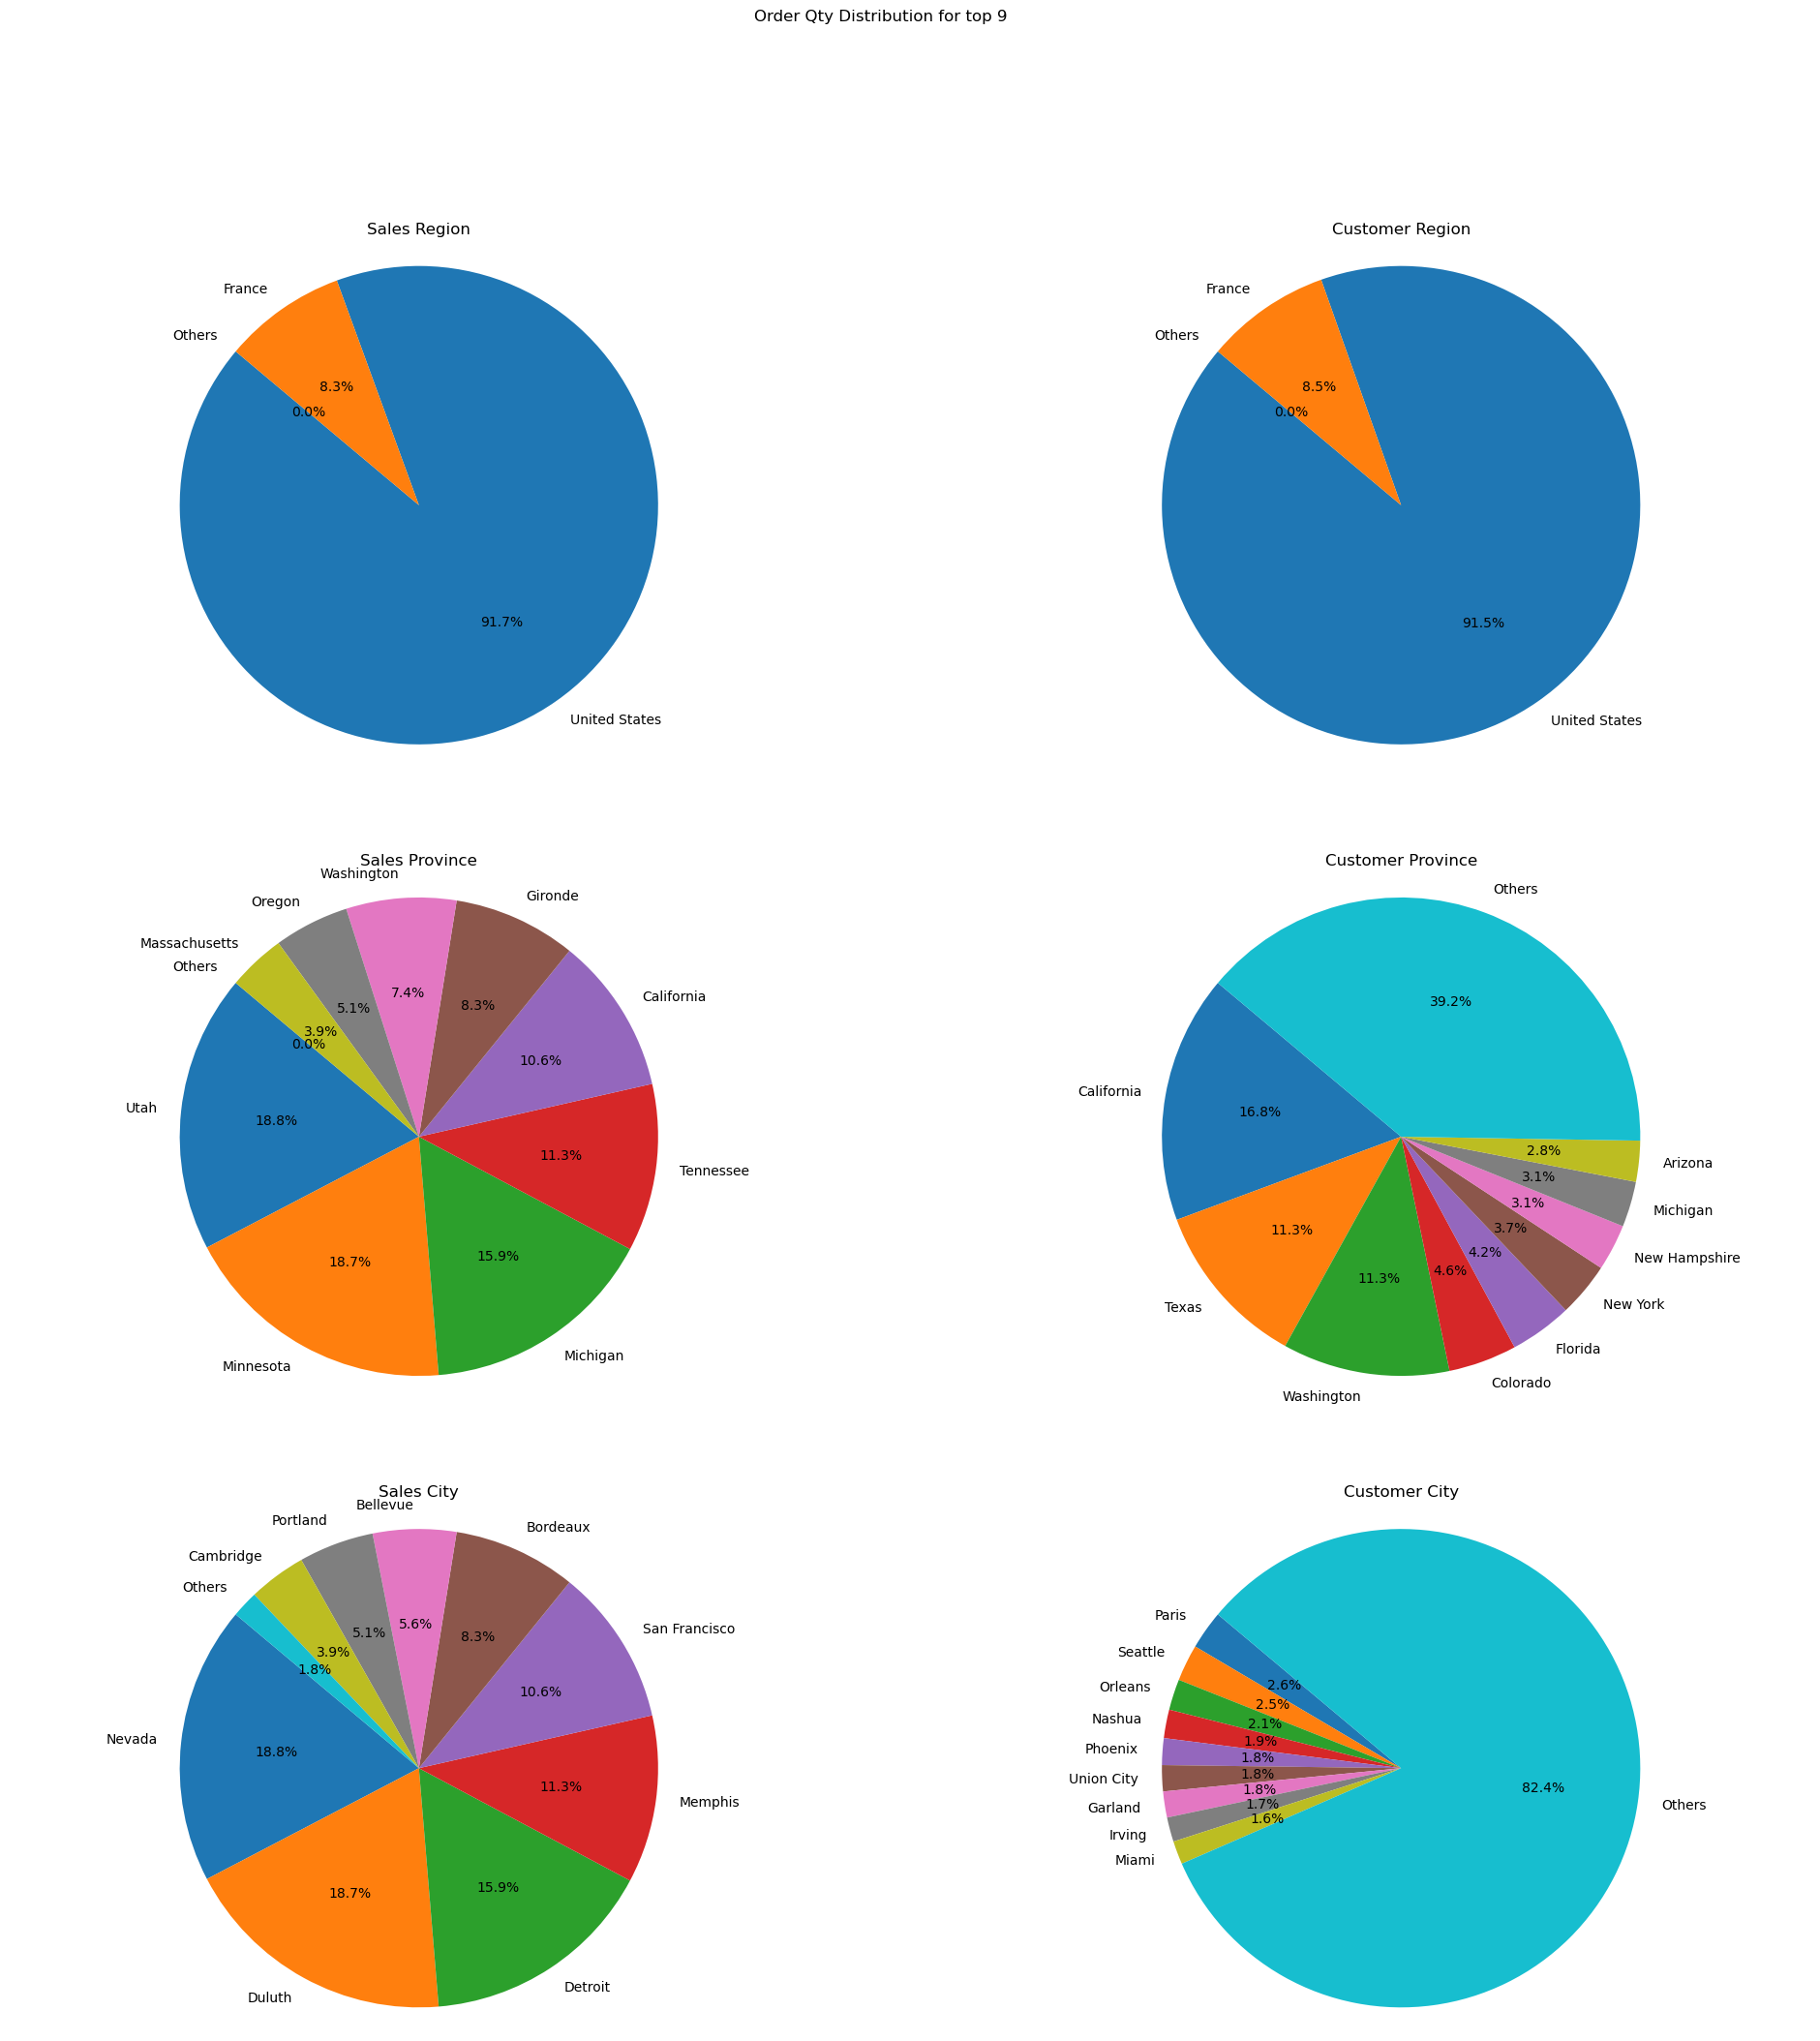

In [123]:
create_pie_plot(sales_data,['Sales Region', 'Customer Region', 'Sales Province', 'Customer Province','Sales City', 'Customer City']
                ,'Order Qty',3,2, 9)

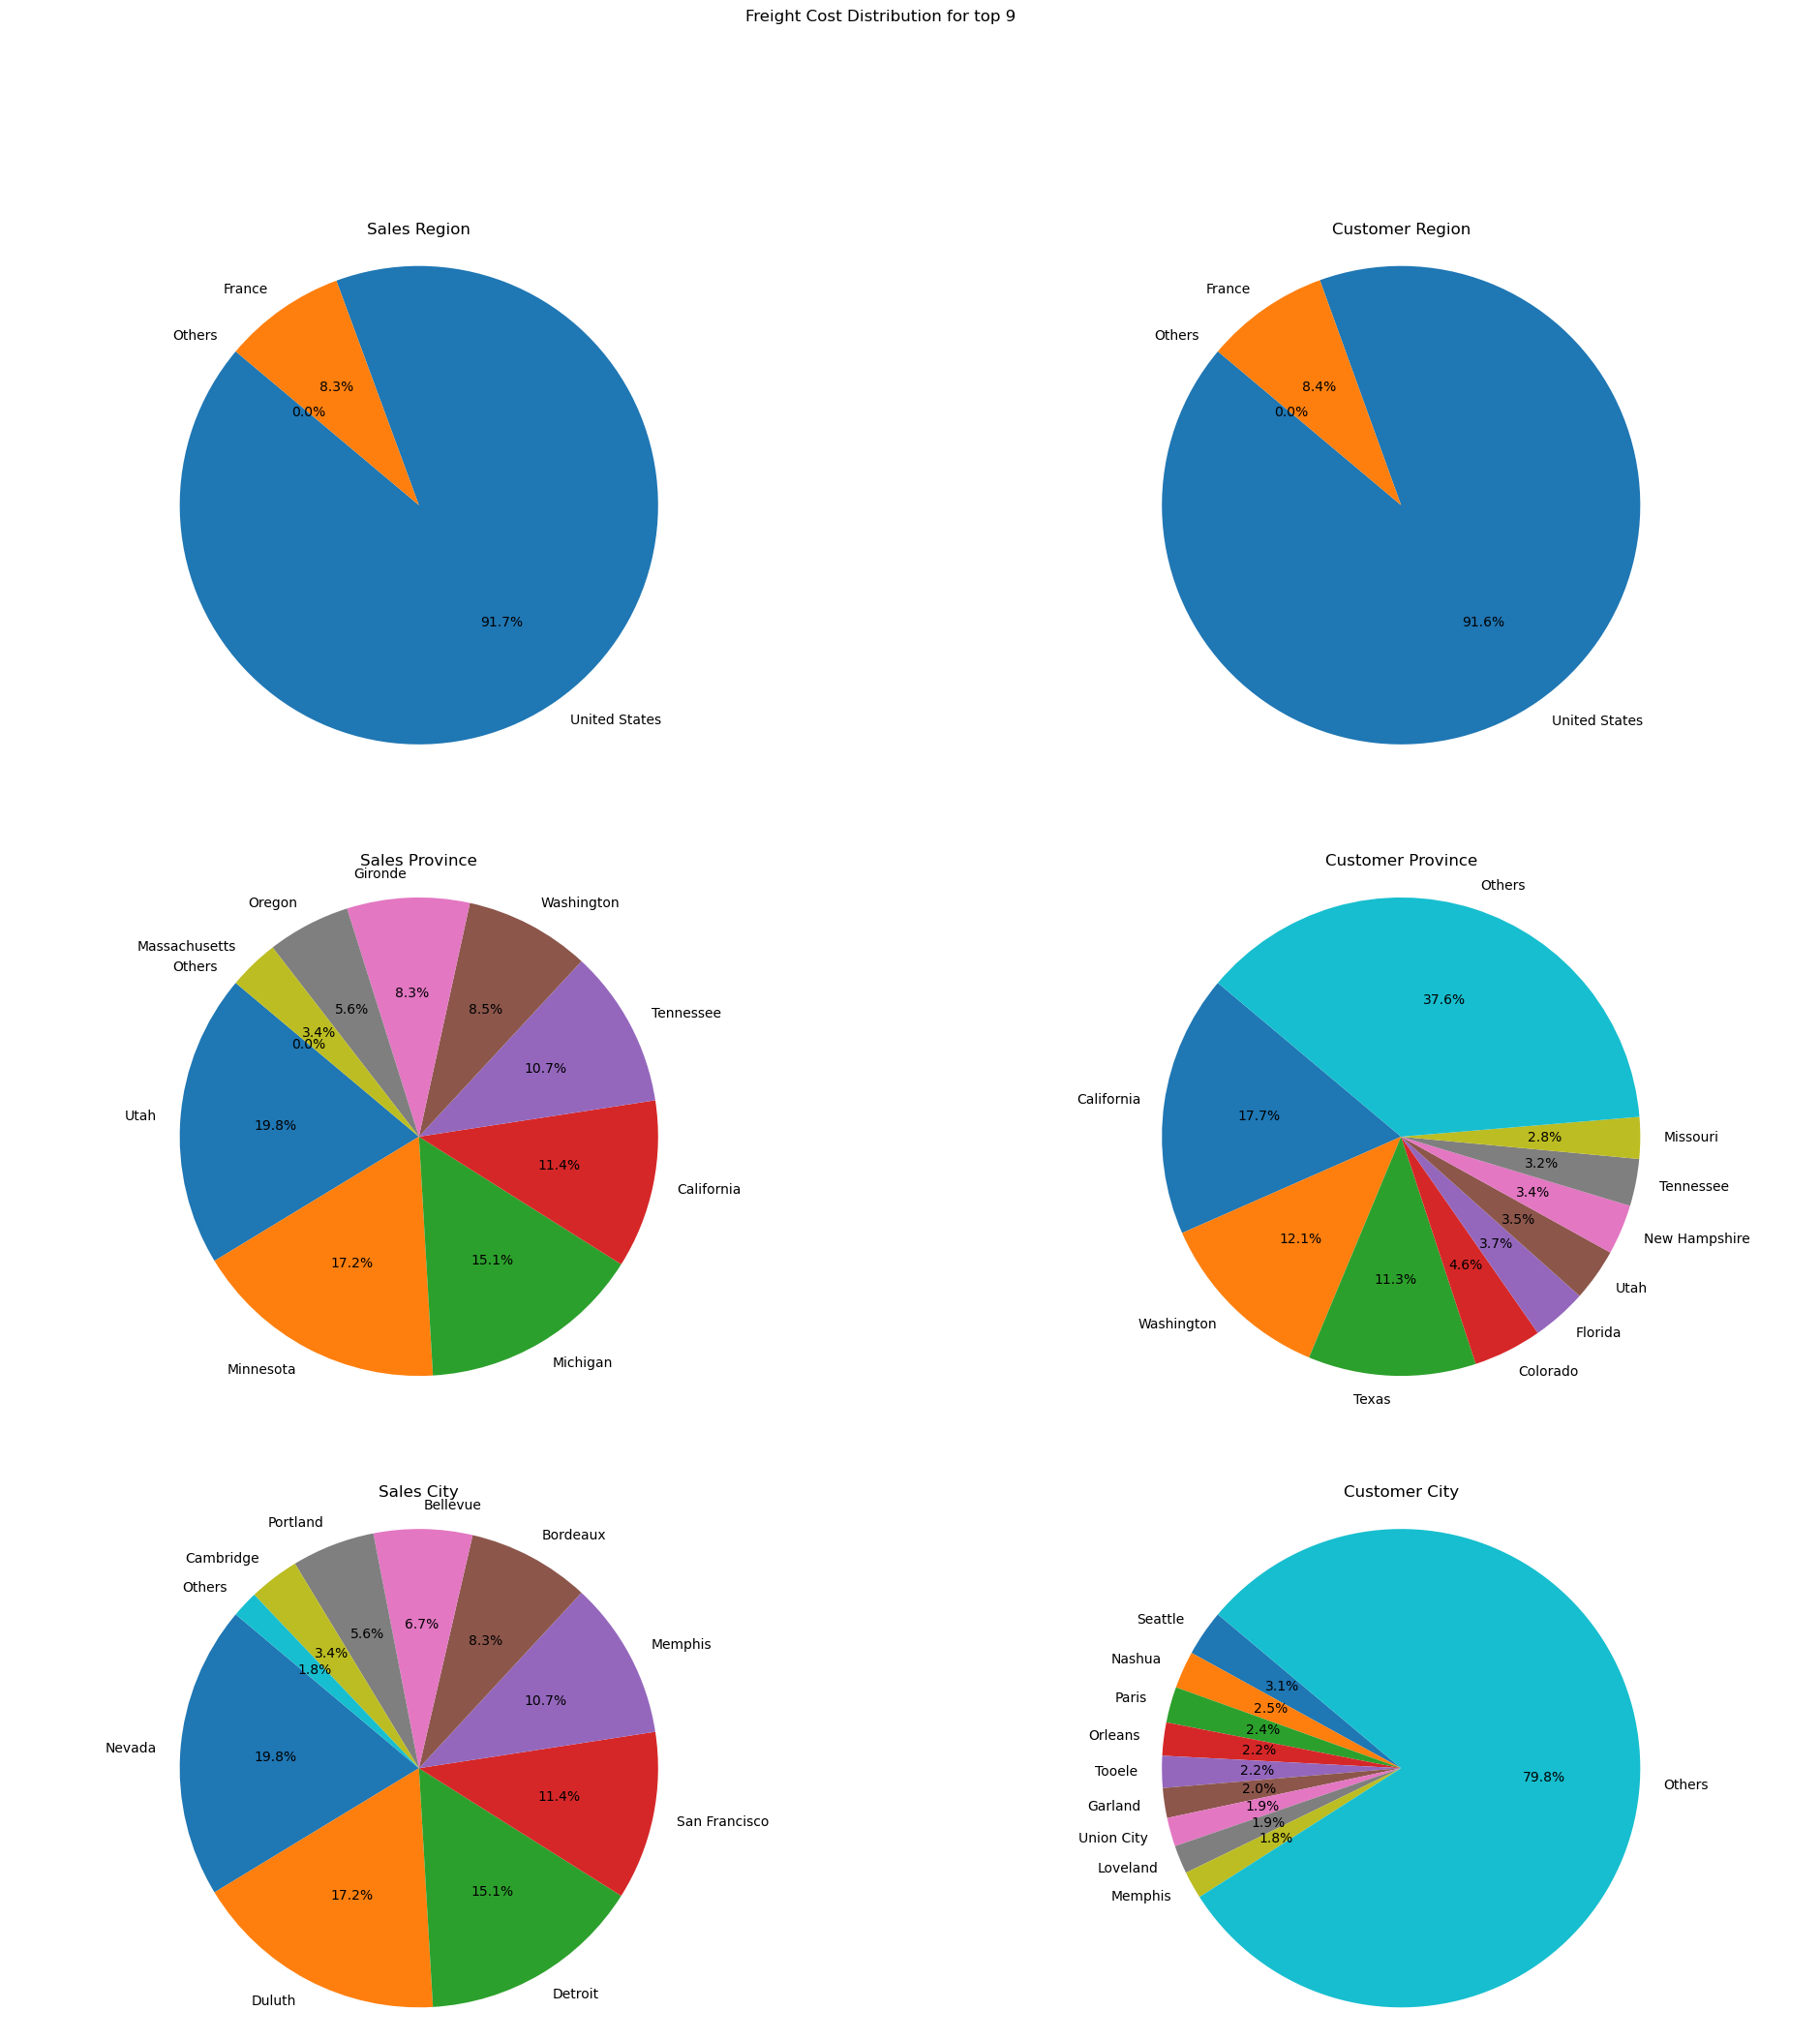

In [124]:
create_pie_plot(sales_data,['Sales Region', 'Customer Region', 'Sales Province', 'Customer Province','Sales City', 'Customer City']
                ,'Freight Cost',3,2, 9)

Note: 
* There are three customer province standing out: California, Texas, Washington ( they have 39.4% share)
* There are 5 sales province standing out: Utah, Minnestoa Michigan, Tennessee, California (they have share 75.3)
* Sales cities with biggest share are in correlation with province( in every important province there is one city -this could be concluded from the plot)
* Customers cities are aproximately uniformly distributed.

Note
* These pie plots are almost the same -> bigger units implies bigger profit which implies bigger freight cost which is exepcted * Freight cost probably depends only on units (there are no province/cities with bigger cost than others so no point in opening store in new place for this reason) 
* But difference in quantity should be examined before and after opening of new store to see if this would help in that way.

### Conclusion: Opening new store won't decrease freight cost

# Share of profits by product category

In [125]:
# this function is similar to ( copy-pasted) used for time series plot, just hue is added
def plot_profit_per_categories_and_quarter(df, category_column):
    time_column = 'Order Date'
    grouped_df = df.groupby([category_column, pd.Grouper(key=time_column, freq='Q')])['Gross Profit'].sum().reset_index()
    grouped_df['Year'] = grouped_df[time_column].dt.year
    grouped_df['Quarter'] = grouped_df[time_column].dt.quarter
    grouped_df['Year Quarter'] = grouped_df['Year'].astype(str) + ' Q' + grouped_df['Quarter'].astype(str)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x='Year Quarter', y='Gross Profit', hue=category_column)
    plt.xlabel('Year Quarter')
    plt.ylabel('Gross Profit')
    plt.title(f'Profit per {category_column} by Year Quarter')
    plt.xticks(rotation=45)
    plt.legend(title=category_column)
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x='Quarter', y='Gross Profit', hue=category_column)
    plt.xlabel('Quarter')
    plt.ylabel('Gross Profit')
    plt.title(f'Profit per {category_column} by Quarter')
    plt.xticks(rotation=45)
    plt.legend(title=category_column)
    plt.show()

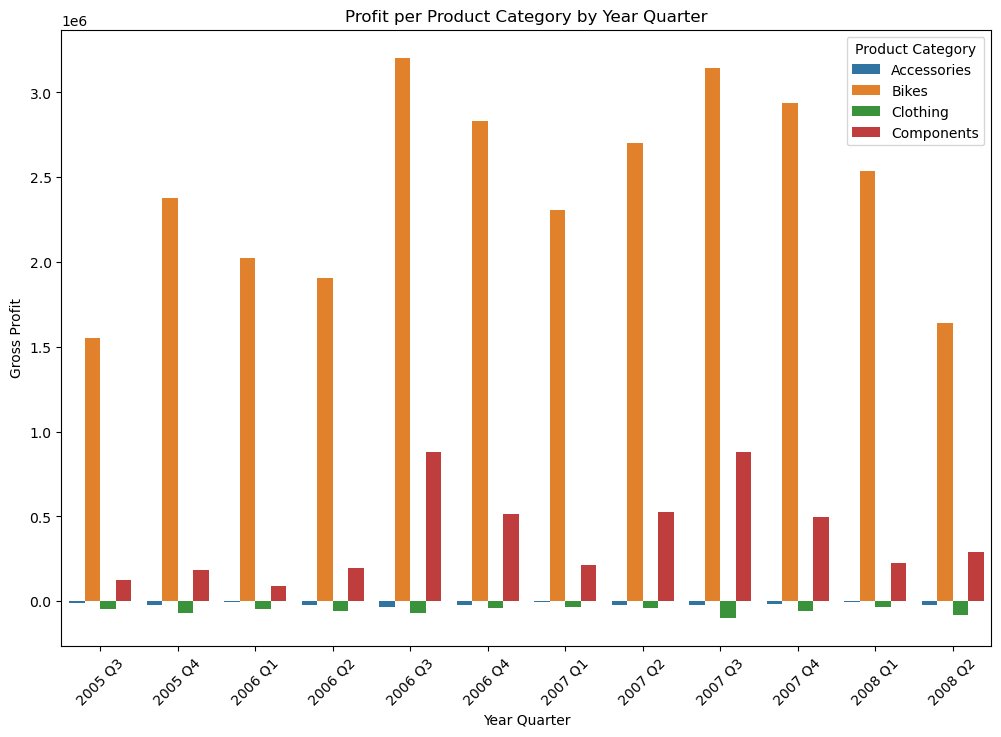

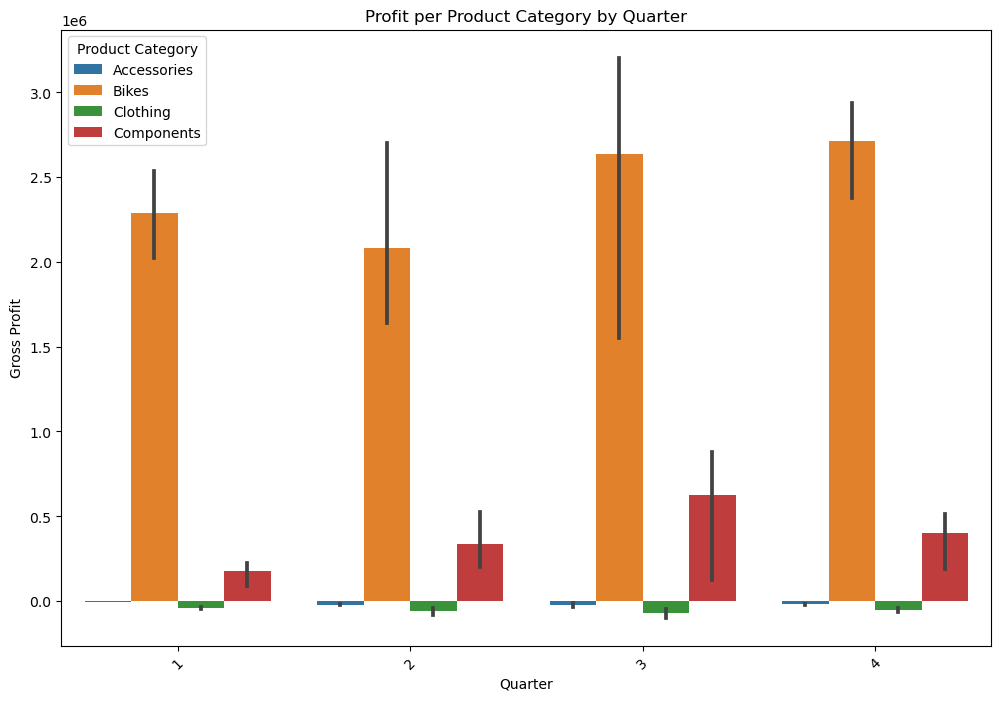

In [126]:
plot_profit_per_categories_and_quarter(sales_data, 'Product Category')

### Conclusion: Even thought not connected to this particular decrease clothing and accessories have negative profit -> we should stop selling these

Note: From now on, only bikes and components are analysed

In [127]:
selected_data = sales_data[sales_data['Product Category'].isin(['Bikes', 'Components'])]

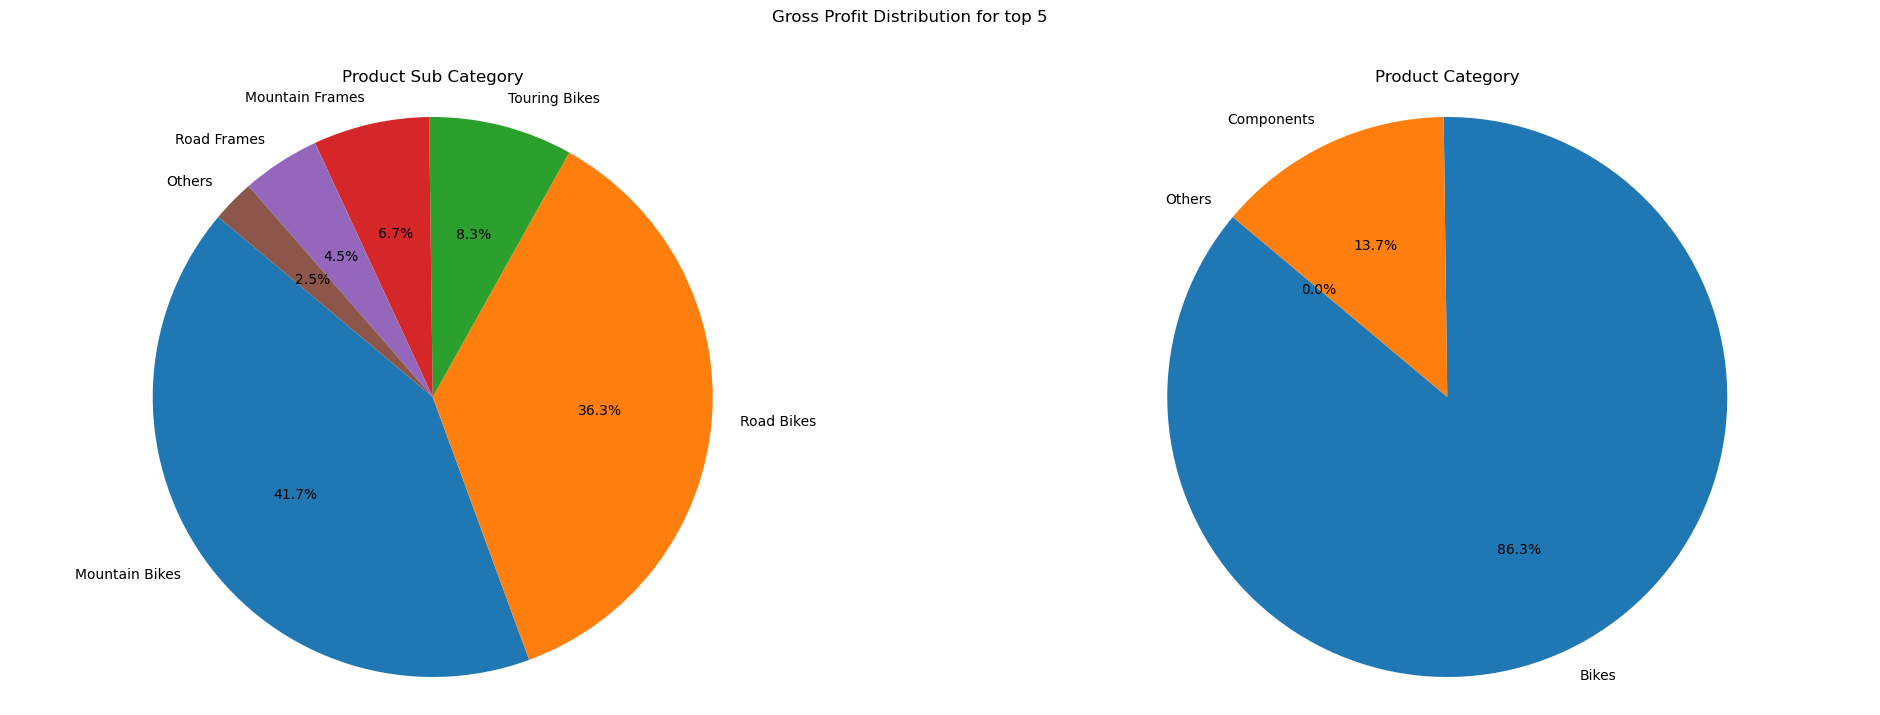

In [128]:
create_pie_plot(selected_data, ['Product Sub Category', 'Product Category'],'Gross Profit', 1, 2, 5)

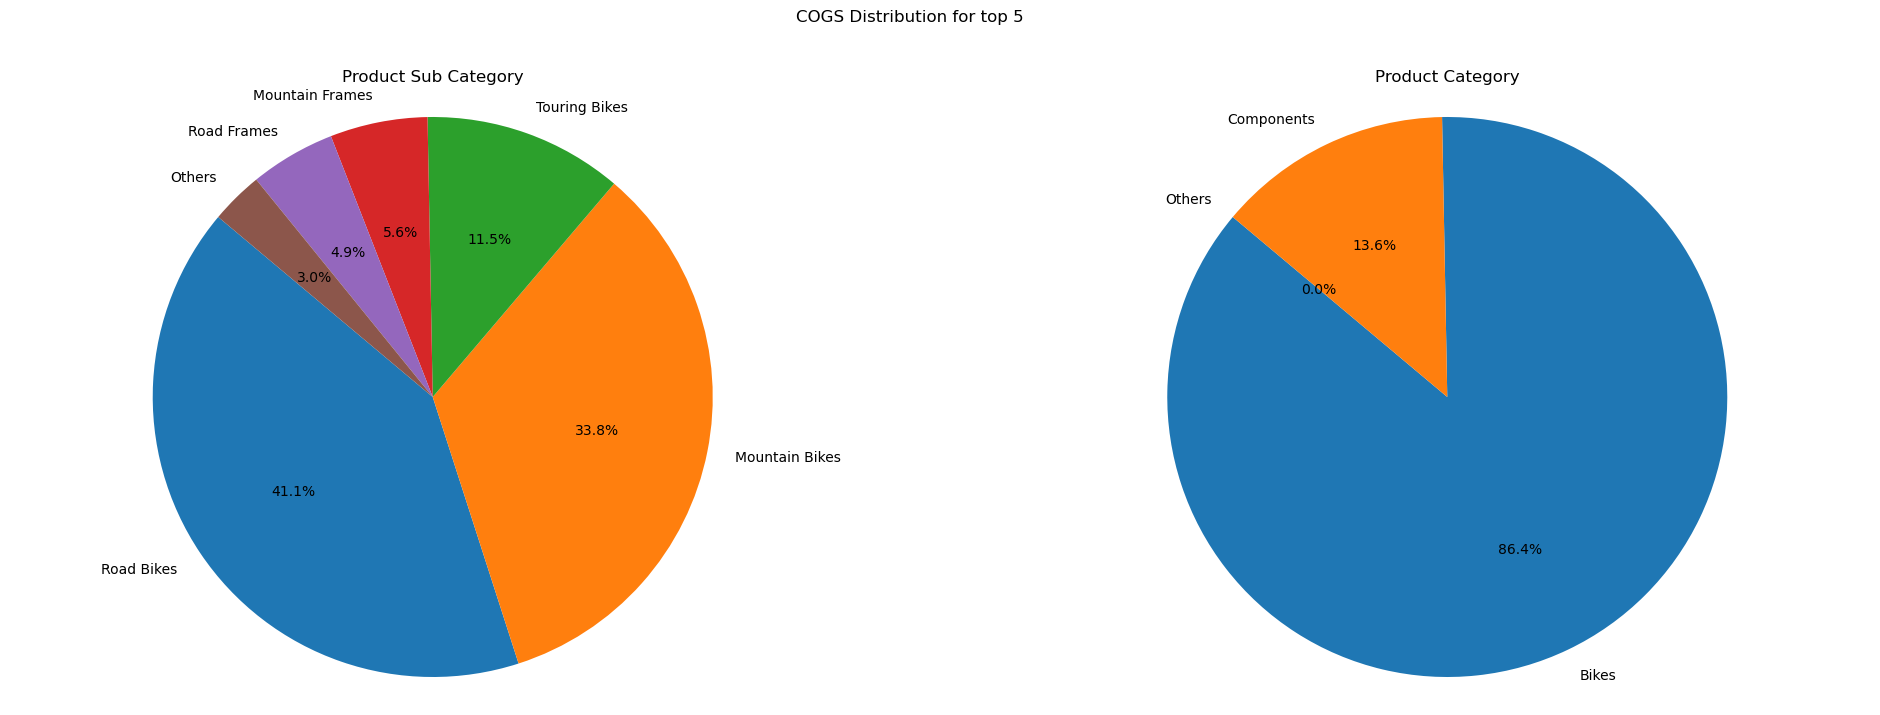

In [129]:
create_pie_plot(selected_data, ['Product Sub Category', 'Product Category'],'COGS', 1, 2, 5)

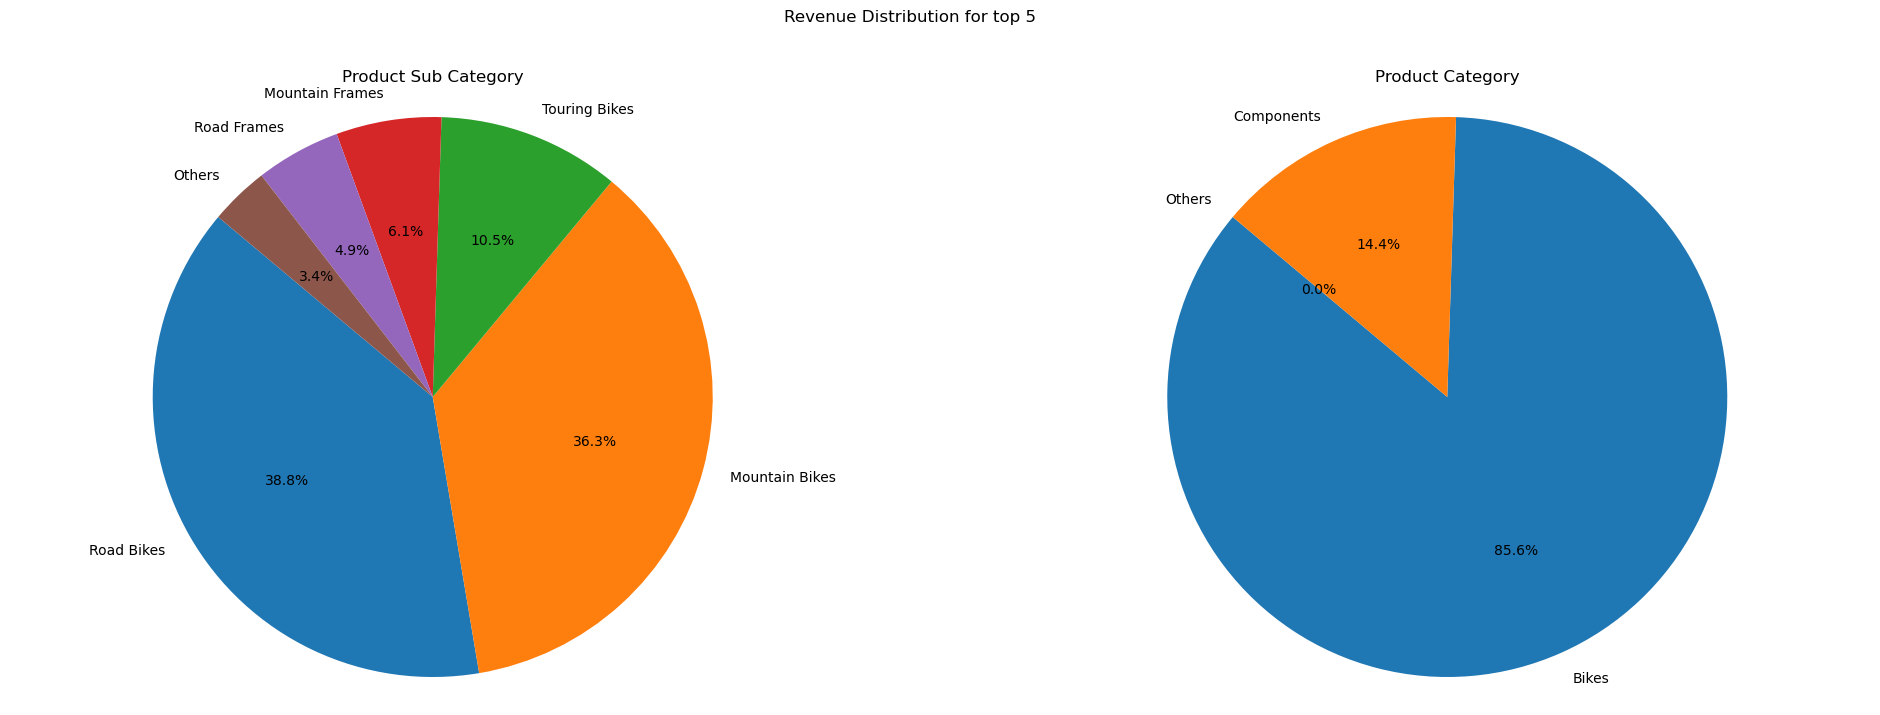

In [130]:
create_pie_plot(selected_data, ['Product Sub Category', 'Product Category'],'Revenue', 1, 2, 5)

We can see that COGS, Revenue and Profit have similar shares

### Question: Which COGS started decreasing Road Bikes or Mountain Bikes?

## Share of products by sale person and Customer

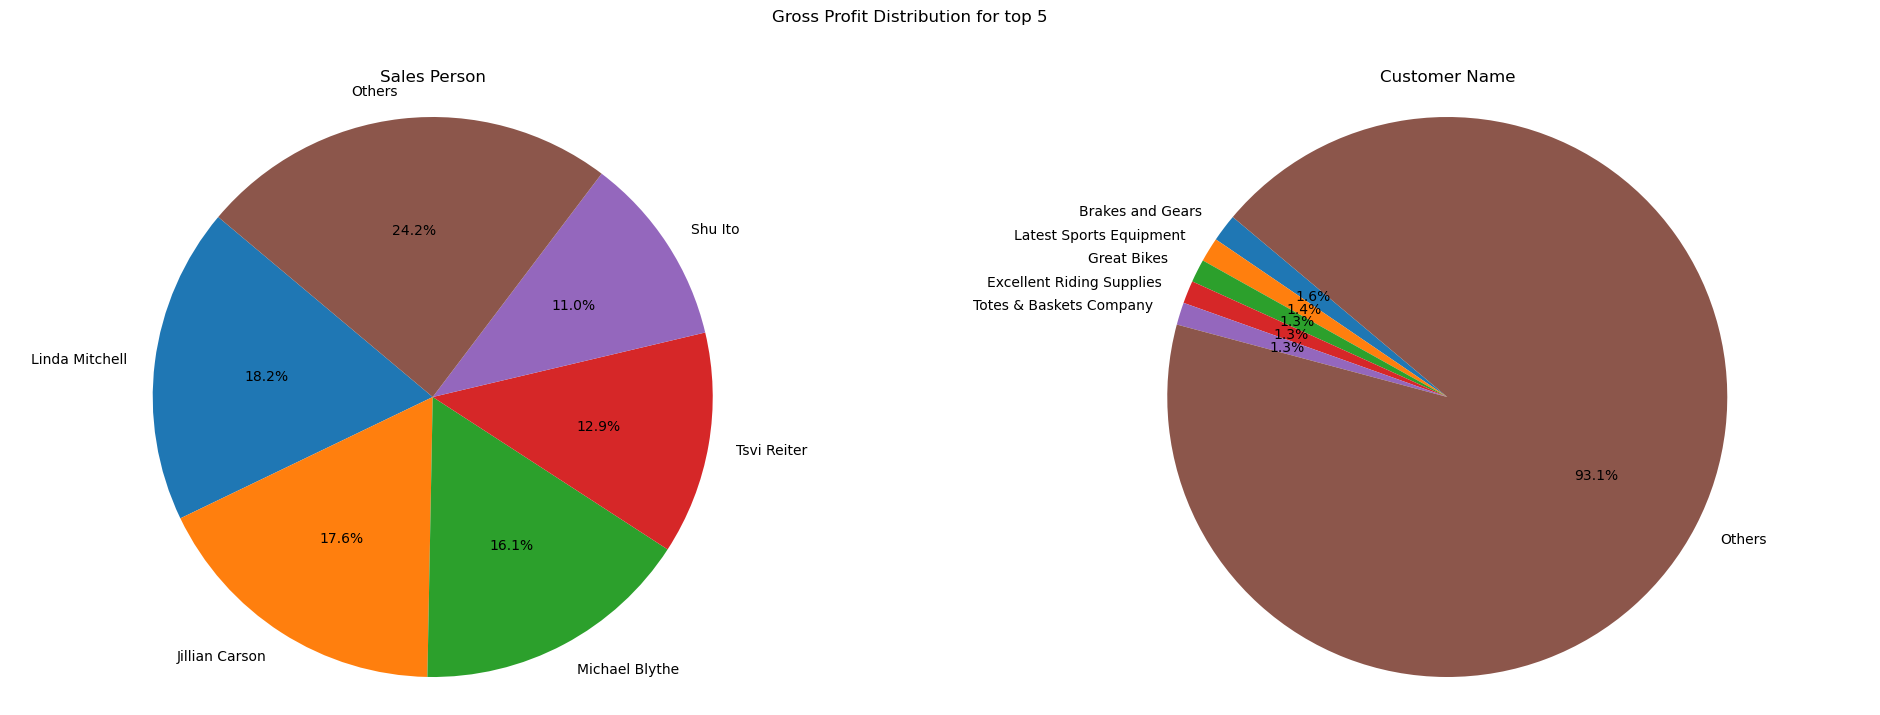

In [131]:
create_pie_plot(selected_data, ['Sales Person', 'Customer Name'],'Gross Profit', 1, 2, 5)

### Conclusion: Customer shares are aproximately uniform -> there are no big customers

Note: There are 5 important sales people

### Final Question: When did increase happen? Did something happen externally short-term at this time?

### Questions summary in priority order:
1. When did increase happen? 
2. Did sudden rise in COGS caused lower profit?
3. Can we solve the problem by increasing the unit price?
4. Which COGS started decreasing Road Bikes or Mountain Bikes?( can we solve it by increasing volume of some category)
5. Is discount impacting later on profits?
6. Can we lower freight cost by opening new store? -> already answered = NO
7. Can we increase quantity by opening new store? -> future work
8. What are different lines and can we increase the profit by choosing/emphasizing the line with biggest slope for some of the feature pairs?
9. Did something happen externally short-term at this time? Is it short-term change? -> partially answered, future work.

# Question 1 analysis

## Trend and seasonality analysis

In [132]:

def plot_decomposition(sales_data,column):
    ''' Decompose data on trend, seasonality and random noise and plot results
        Inputs:
            sales_data - dataframe with datetime index on which we want to apply this
            column - column which we want to decompose
        Outputs: decomposition - resulting decomposition of the column
    '''
    df = pd.DataFrame()
    df[column] = sales_data[column]
    decomposition = seasonal_decompose(df, model='additive', period = 12)
    decomposition.plot()
    plt.suptitle('Time Series Decomposition of Monthly '+ column, fontsize = 10)
    plt.show()
    return decomposition

In [133]:
def detect_decreasing_trend(trend_values, decrease_threshold=3):
    '''
        Given trend values determine all points where trend was decreasing for decrease_threshold previous timesteps
        Inputs:
            trend_values - values of the trend
            decrease_threshold - minimum number of timesteps for trend to decrease for point to be detected
        Outputs:
            decreasing indices - all indices for which condition si met
    '''
    consecutive_decreases = 0
    decreasing_indices = []

    for i in range(1, len(trend_values)):
        diff = trend_values[i] - trend_values[i-1]
        if diff < 0:
            consecutive_decreases += 1
        else:
            consecutive_decreases = 0

        if consecutive_decreases >= decrease_threshold:
            decreasing_indices.append(i)

    return decreasing_indices

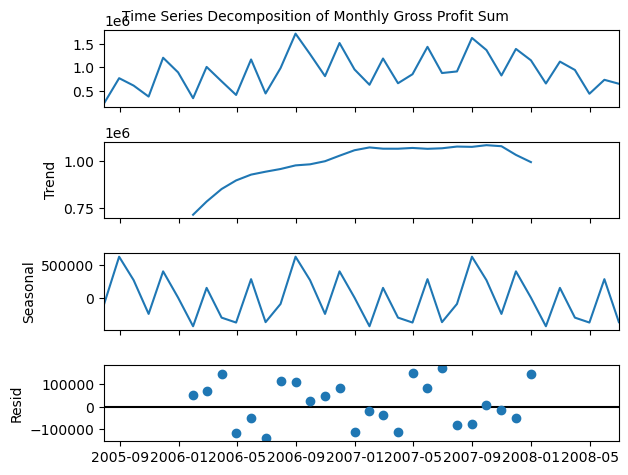

In [134]:
profit_decomposition = plot_decomposition(profit_per_month, 'Gross Profit Sum')

### Question 9. answer: it seems that while seasonality has some impact on profit decrease, main component of decrease is decrease of trend and there are no random factors suggesting decrease but this can be further analysed by reading more about whether some external factors happened which caused trend to decrease. But it wasn't short-term change.

In [135]:
decreasing_indices = detect_decreasing_trend(profit_decomposition.trend)
decreasing_indices

[29]

In [136]:
decreasing_index = decreasing_indices[0] -2

In [137]:
decreasing_time = profit_per_month.index[decreasing_index]
decreasing_value = profit_decomposition.trend[decreasing_index]

Text(0.5, 1.0, 'Trend is starting to fall down on October 2007')

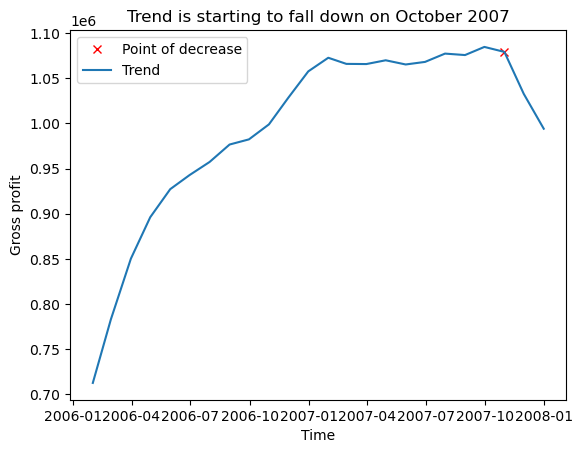

In [138]:
plt.figure()
plt.plot(decreasing_time, decreasing_value,'rx')
plt.plot(profit_decomposition.trend)
plt.legend(['Point of decrease','Trend'])
plt.ylabel('Gross profit')
plt.xlabel('Time')
plt.title('Trend is starting to fall down on October 2007')

### Question 1 answer: Decrease in profit trend happend on October 2007.

# Question 2 and 3 analysis

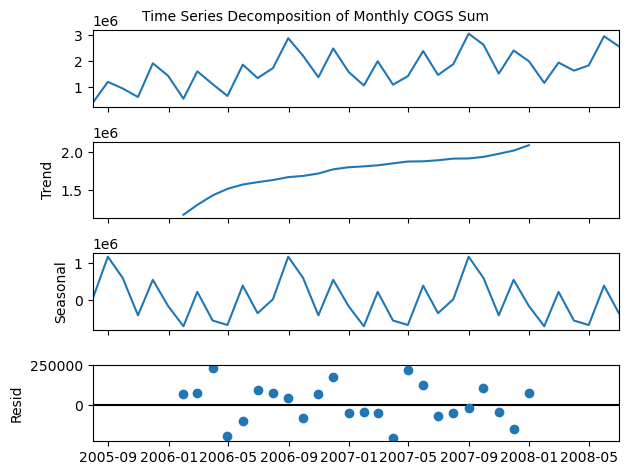

In [139]:
cogs_decomposition = plot_decomposition(cogs_per_month, 'COGS Sum')

Text(0.5, 1.0, 'Trend is starting to increase suddenly on October 2007')

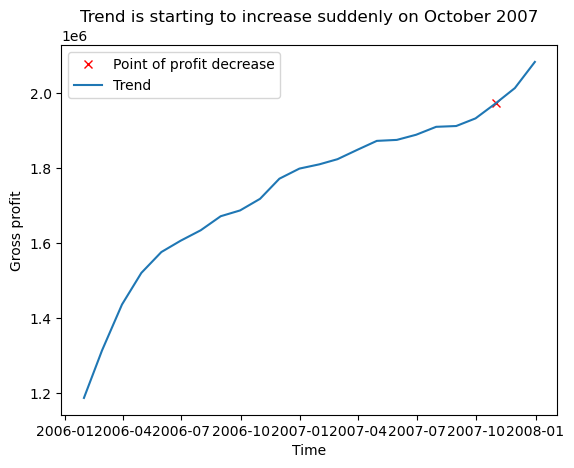

In [140]:
increasing_value = cogs_decomposition.trend[decreasing_time]
plt.figure()
plt.plot(decreasing_time, increasing_value,'rx')
plt.plot(cogs_decomposition.trend)
plt.xlabel('Time')
plt.ylabel('Gross profit')
plt.legend(['Point of profit decrease','Trend'])
plt.title('Trend is starting to increase suddenly on October 2007')

Note: We can see from image that increase in COGS happend about two months before decrease in profit.

In [141]:
start_time = sales_per_month.index[decreasing_index-2]

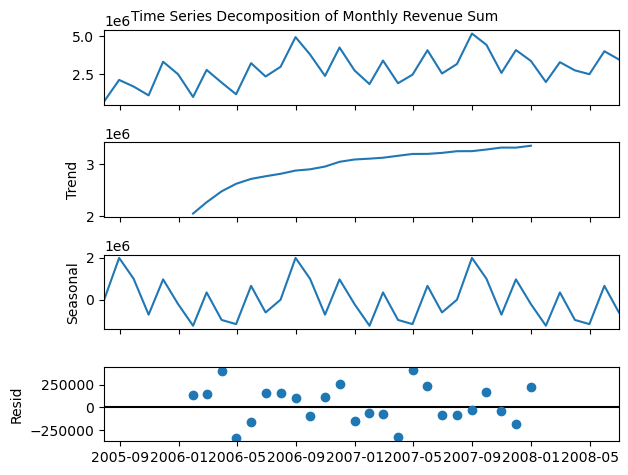

In [142]:
revenue_decomposition = plot_decomposition(revenue_per_month, 'Revenue Sum')

Text(0.5, 1.0, 'Change of correlation between COGS and Revenue')

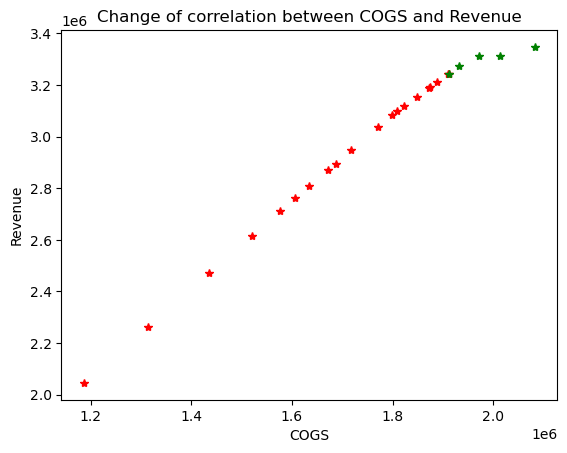

In [143]:
plt.figure()
plt.plot(cogs_decomposition.trend[:start_time],revenue_decomposition.trend[:start_time],'r*')
plt.plot(cogs_decomposition.trend[start_time:],revenue_decomposition.trend[start_time:],'g*')
plt.xlabel('COGS')
plt.ylabel('Revenue')
plt.title('Change of correlation between COGS and Revenue')

In [144]:
# check for normality using Shapiro-Wilk test
cogs_normality = stats.shapiro(sales_per_month['COGS Sum'])
revenue_normality = stats.shapiro(sales_per_month['Revenue Sum'])

print("Normality test for COGS:", cogs_normality)
print("Normality test for Revenue:", revenue_normality)

Normality test for COGS: ShapiroResult(statistic=0.9801819920539856, pvalue=0.7514952421188354)
Normality test for Revenue: ShapiroResult(statistic=0.9856811165809631, pvalue=0.9128972291946411)


Note: These are normally distributed and since sales_data has a lot of samples because of the central limit theorem we can assume it is nirmally distributed

In [145]:
period_before = sales_data[sales_data['Order Date']<decreasing_time]
period_after = sales_data[sales_data['Order Date']>=decreasing_time]

In [146]:
sales_per_month. columns = ['Profit', 'Month', 'Year', 'Revenue', 'Discount','COGS', 'Freight', 'Quantity', 'Margin']

In [147]:
sales_per_month.columns

Index(['Profit', 'Month', 'Year', 'Revenue', 'Discount', 'COGS', 'Freight',
       'Quantity', 'Margin'],
      dtype='object')

In [148]:
# Fit the regression model with multiple independent variables
model = ols('Revenue ~ COGS', data=sales_per_month).fit()

# Display the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     743.2
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.09e-24
Time:                        01:31:19   Log-Likelihood:                -495.37
No. Observations:                  36   AIC:                             994.7
Df Residuals:                      34   BIC:                             997.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.599e+05   1.05e+05      1.526      0.1

In [149]:
# Fit the regression model with multiple independent variables
model_before = ols('Revenue ~ COGS', data=period_before).fit()

# Display the model summary
print(model_before.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.331e+06
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        01:31:19   Log-Likelihood:            -2.1149e+05
No. Observations:               29694   AIC:                         4.230e+05
Df Residuals:                   29692   BIC:                         4.230e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4965      2.059      6.555      0.0

In [150]:
# Fit the regression model with multiple independent variables
model_after = ols('Revenue ~ COGS', data=period_after).fit()

# Display the model summary
print(model_after.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 5.103e+05
Date:                Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                        01:31:19   Log-Likelihood:                -93653.
No. Observations:               12189   AIC:                         1.873e+05
Df Residuals:                   12187   BIC:                         1.873e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     70.2459      5.527     12.710      0.0

In [151]:
(1.70-1.48)/1.70

0.12941176470588234

-> slope has changed for 13%

In [152]:
predicted_revenue = pd.DataFrame()
predicted_revenue['Revenue'] = model_before.predict(sales_per_month['COGS'])

Text(0.5, 1.0, 'Linear regression result')

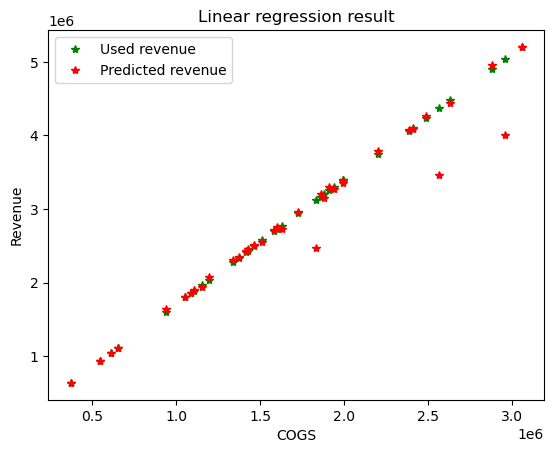

In [153]:
plt.figure()
plt.plot(sales_per_month['COGS'], predicted_revenue['Revenue'],'g*')
plt.plot(sales_per_month['COGS'], sales_per_month['Revenue'],'r*')
plt.legend(['Used revenue','Predicted revenue'])
plt.xlabel('COGS')
plt.ylabel('Revenue')
plt.title('Linear regression result')

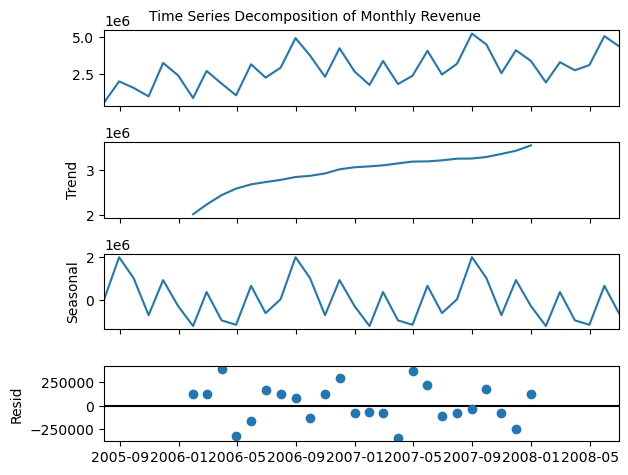

In [154]:
predicted_decomposition =  plot_decomposition(predicted_revenue, 'Revenue')

In [155]:
plt.figure()
plt.plot(cogs_decomposition.trend, predicted_decomposition.trend,'g')
plt.plot(cogs_decomposition.trend, revenue_decomposition.trend,'r')
plt.legend(['Predicted revenue vs COGS trend','Current revenue vs COGS trend'])
plt.xlabel('COGS trend')
plt.ylabel('Revenue trend')
plt.title('Trend of linear regression result')

Text(0.5, 1.0, 'Trend of linear regression result')

With this we proved causality and that regression coeficient decreased -> revenue decreased in comparison to COGS

### Conclusion: Correlation between Revenue and COGS happened because of decrease of COGS which lead to lower profit, and we should increase revenue to solve this problem.

### Added Question: could this impact quantity sold?

In [156]:
model = ols('Quantity ~ Revenue', data=sales_per_month).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     136.4
Date:                Thu, 06 Jun 2024   Prob (F-statistic):           1.89e-13
Time:                        01:31:20   Log-Likelihood:                -302.35
No. Observations:                  36   AIC:                             608.7
Df Residuals:                      34   BIC:                             611.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1494.8137    507.488     -2.946      0.0

### Added answer: this will impact the quantity but for only 0.002 per one increase in revenue which is not much.

# Question 4  and 8 analysis

In [157]:
road_bikes_before = period_before[period_before['Product Sub Category'] == 'Road Bikes']
mountain_bikes_before = period_before[period_before['Product Sub Category'] == 'Mountain Bikes']
bikes_before = period_before[period_before['Product Category'] == 'Bikes']
components_before = period_before[period_before['Product Category'] == 'Components']

In [158]:
road_bikes_after = period_after[period_after['Product Sub Category'] == 'Road Bikes']
mountain_bikes_after = period_after[period_after['Product Sub Category'] == 'Mountain Bikes']
bikes_after = period_after[period_after['Product Category'] == 'Bikes']
components_after = period_after[period_after['Product Category'] == 'Components']

Text(0.5, 1.0, 'Road bikes: Revenue vs COGS data')

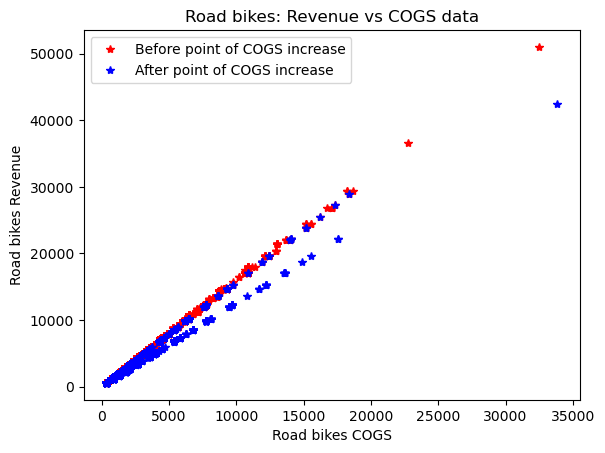

In [159]:
plt.figure()
plt.plot(road_bikes_before['COGS'], road_bikes_before['Revenue'],'r*')
plt.plot(road_bikes_after['COGS'], road_bikes_after['Revenue'],'b*')
plt.xlabel('Road bikes COGS')
plt.ylabel('Road bikes Revenue')
plt.legend(['Before point of COGS increase','After point of COGS increase'])
plt.title('Road bikes: Revenue vs COGS data')

Text(0.5, 1.0, 'Mountain bikes: Revenue vs COGS data')

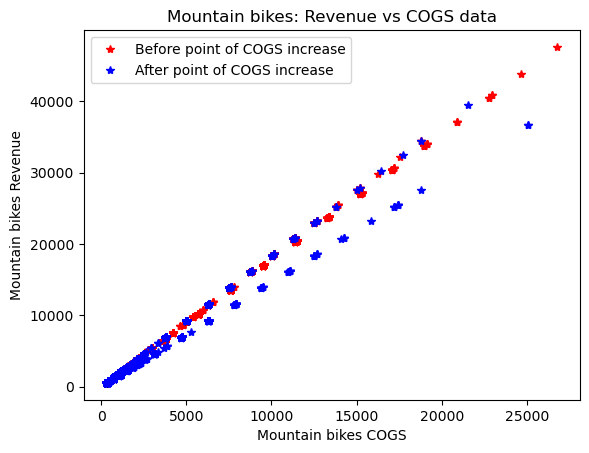

In [160]:
plt.figure()
plt.plot(mountain_bikes_before['COGS'], mountain_bikes_before['Revenue'],'r*')
plt.plot(mountain_bikes_after['COGS'], mountain_bikes_after['Revenue'],'b*')
plt.xlabel('Mountain bikes COGS')
plt.ylabel('Mountain bikes Revenue')
plt.legend(['Before point of COGS increase','After point of COGS increase'])
plt.title('Mountain bikes: Revenue vs COGS data')

In [161]:
plt.figure()
plt.plot(bikes_before['COGS'], bikes_before['Revenue'],'r*')
plt.plot(bikes_after['COGS'], bikes_after['Revenue'],'b*')
plt.xlabel('Bikes COGS')
plt.ylabel('Bikes Revenue')
plt.legend(['Before point of COGS increase','After point of COGS increase'])
plt.title('Bikes: Revenue vs COGS data')

Text(0.5, 1.0, 'Bikes: Revenue vs COGS data')

In [162]:
plt.figure()
plt.plot(components_before['COGS'], components_before['Revenue'],'r*')
plt.plot(components_after['COGS'], components_after['Revenue'],'b*')
plt.xlabel('components COGS')
plt.ylabel('Components Revenue')
plt.legend(['Before point of COGS increase','After point of COGS increase'])
plt.title('Components: Revenue vs COGS data')

Text(0.5, 1.0, 'Components: Revenue vs COGS data')

## Conclusion: There is no difference between different categories except from how much we should increase the price. It is best to focus on products with biggest profit share, and to increase the price for all products.

## Conclusion: Different lines can represent either different (sub)categories of products or different time periods.

# Question 5 analysis

In [163]:
change_point_1 = sales_per_month.index[11]

In [164]:
change_point_1

Timestamp('2006-06-30 00:00:00')

In [165]:
change_point_2 = sales_per_month.index[24]

In [166]:
change_point_2

Timestamp('2007-07-31 00:00:00')

In [167]:
sales_per_month['Prev Month Discount'] = sales_per_month['Discount'].shift(1)
before_point_1 = sales_per_month[sales_per_month.index<change_point_1]
between_point_1_2= sales_per_month[(sales_per_month.index>=change_point_1) & (sales_per_month.index<change_point_2)   ]
after_point_2 = sales_per_month[(sales_per_month.index>=change_point_2)  ]

Text(0.5, 1.0, 'Profit vs Dicount')

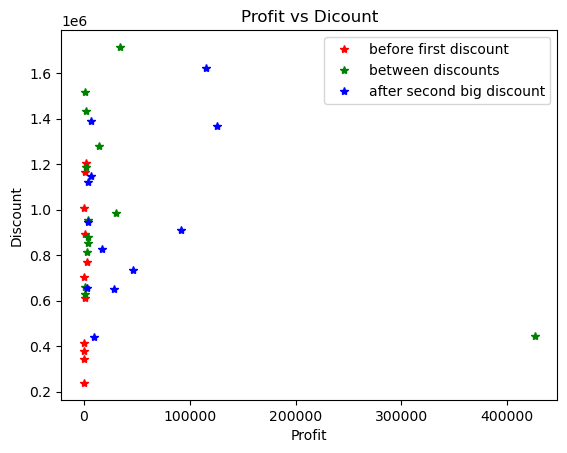

In [168]:
plt.plot(before_point_1['Discount'], before_point_1['Profit'],'r*')
plt.plot(between_point_1_2['Discount'], between_point_1_2['Profit'],'g*')
plt.plot(after_point_2['Discount'], after_point_2['Profit'],'b*')
plt.xlabel('Profit')
plt.ylabel('Discount')
plt.legend(['before first discount', 'between discounts','after second big discount'])
plt.title('Profit vs Dicount')

In [169]:
plt.plot(before_point_1['Prev Month Discount'], before_point_1['Profit'],'r*')
plt.plot(between_point_1_2['Prev Month Discount'], between_point_1_2['Profit'],'g*')
plt.plot(after_point_2['Prev Month Discount'], after_point_2['Profit'],'b*')
plt.xlabel('Profit')
plt.ylabel('Discount in previous month')
plt.legend(['before first discount', 'between discounts','after second big discount'])
plt.title('Profit vs Dicount in previous month')

Text(0.5, 1.0, 'Profit vs Dicount in previous month')

In [170]:
plt.plot(before_point_1['Discount'], before_point_1['Quantity'],'r*')
plt.plot(between_point_1_2['Discount'], between_point_1_2['Quantity'],'g*')
plt.plot(after_point_2['Discount'], after_point_2['Quantity'],'b*')
plt.xlabel('Quantity')
plt.ylabel('Discount')
plt.legend(['before first discount', 'between discounts','after second big discount'])
plt.title('Quantity vs Discount')

Text(0.5, 1.0, 'Quantity vs Discount')

In [171]:
plt.plot(before_point_1['Prev Month Discount'], before_point_1['Quantity'],'r*')
plt.plot(between_point_1_2['Prev Month Discount'], between_point_1_2['Quantity'],'g*')
plt.plot(after_point_2['Prev Month Discount'], after_point_2['Quantity'],'b*')
plt.xlabel('Quantity')
plt.ylabel('Discount from previous month')
plt.legend(['before first discount', 'between discounts','after second big discount'])
plt.title('Quantity vs Dicount from previous month')

Text(0.5, 1.0, 'Quantity vs Dicount from previous month')

## Conclusion: we can see there is no evident correlation between discount and price, but there is an increase in mean profit after discount but is not proportional to discount quantity.

In [172]:
sales_data['Period'] = 'Between'
sales_data.loc[sales_data['Order Date']<change_point_1,'Period'] = 'Before'
sales_data.loc[sales_data['Order Date']>=change_point_2,'Period'] = 'After'

In [173]:
sales_data = sales_data.rename(columns = {'Gross Profit': 'Profit'})

In [174]:
# fit ANCOVA model
model = ols('Profit ~ Discount + C(Period)', data=sales_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     366.6
Date:                Thu, 06 Jun 2024   Prob (F-statistic):          5.02e-235
Time:                        01:31:24   Log-Likelihood:            -3.6365e+05
No. Observations:               41883   AIC:                         7.273e+05
Df Residuals:                   41879   BIC:                         7.274e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              596.9579 

In [176]:
sales_per_month['Period'] = 'Between'
sales_per_month.loc[sales_per_month.index<change_point_1,'Period'] = 'Before'
sales_per_month.loc[sales_per_month.index>=change_point_2,'Period'] = 'After'

sales_per_month = sales_per_month.rename(columns = {'Gross Profit': 'Profit'})

# fit ANCOVA model
model = ols('Profit ~ Discount + C(Period)', data=sales_per_month).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     2.097
Date:                Thu, 06 Jun 2024   Prob (F-statistic):              0.120
Time:                        01:36:03   Log-Likelihood:                -509.45
No. Observations:                  36   AIC:                             1027.
Df Residuals:                      32   BIC:                             1033.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.012e+06 

## Conclusion: There is significant change in mean of profit before and after discount times

# COMMENT I didn't have time to analyse discounts in more depth, this is just proof of concept what I would do to see the impacts. Similar should be done for previous discount. Also correlation between moving discount and profit should be found to see if previous discounts have some impact on current profit.